
SumSquares:

GP EI: exact versus approximate partial-order GP EI derivatives wrt **x1**, **x2**, **x3**, **x4**

In [1]:
pip install pyGPGO


  Created wheel for pyGPGO: filename=pyGPGO-0.5.1-py3-none-any.whl size=19880 sha256=ae8e6753205a4646590560ab9e37cd7eaef1cddd040f28ebdf28204bd304f387
  Stored in directory: /root/.cache/pip/wheels/c8/5d/0b/2160114e2f1b87791c51b66cf07f89831dbb6f49167950316f
Successfully built pyGPGO


In [2]:
### Import:

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import itertools

from pyGPGO.GPGO import GPGO
from pyGPGO.surrogates.GaussianProcess import GaussianProcess
from pyGPGO.acquisition import Acquisition
from pyGPGO.covfunc import squaredExponential

from joblib import Parallel, delayed
from numpy.linalg import solve, cholesky
from scipy.spatial.distance import cdist
from scipy.optimize import minimize
from scipy.stats import norm
import time

warnings.filterwarnings("ignore", category=RuntimeWarning)


In [3]:
n_start_AcqFunc = 100 #multi-start iterations to avoid local optima in AcqFunc optimization


In [4]:
### Inputs:

func = 'SumSquares'
n_test = 500
eps = 1e-08

util_grad_exact = 'dEI_GP'
util_grad_approx = 'ExpectedImprovement'

n_init = 5 # random initialisations
iters = 40
opt = True

In [5]:
### Objective Function - Sum Squares(x) 4-D:

def objfunc(x1_training, x2_training, x3_training, x4_training):
            return  operator * (  1 * x1_training ** 2
                            + 2 * x2_training ** 2
                            + 3 * x3_training ** 2
                            + 4 * x4_training ** 2
                            )
        
# Constraints:
lb = -10
ub = +10
    
# Input array dimension(s):
dim = 4

# 4-D inputs' parameter bounds:
param = {'x1_training': ('cont', [lb, ub]),
                 'x2_training': ('cont', [lb, ub]),
                 'x3_training': ('cont', [lb, ub]),
                 'x4_training': ('cont', [lb, ub])}
    
# True y bounds:
y_lb = 0
operator = -1 # targets global minimum 
y_global_orig = y_lb * operator # targets global minimum
    
# Test data:
x1_test = np.linspace(lb, ub, n_test)
x2_test = np.linspace(lb, ub, n_test)
x3_test = np.linspace(lb, ub, n_test)
x4_test = np.linspace(lb, ub, n_test)
Xstar = np.column_stack((x1_test, x2_test, x3_test, x4_test))
    

In [6]:
### Cumulative Regret Calculator:

def min_max_array(x):
    new_list = []
    for i, num in enumerate(x):
            new_list.append(np.min(x[0:i+1]))
    return new_list
  

In [7]:
### Surrogate derivatives: 

cov_func = squaredExponential()

def kronDelta(X, Xstar):
    return cdist(X, Xstar) < np.finfo(np.float32).eps

def se(X, Xstar, sigmaf, l, sigman):
    return sigmaf * np.exp(-0.5 * cdist(X, Xstar) ** 2 / l ** 2) + sigman * kronDelta(X, Xstar)

def deriv_se(X, Xstar, sigmaf, l, sigman):
    return cdist(X, Xstar) / (l ** 2) * se(X, Xstar, sigmaf, l, sigman)

def der_covmat(X, Xstar, sigmaf, l, sigman):
      nx = len(X)
      ny = len(Xstar)
      return np.round(np.array([deriv_se(np.atleast_2d(i), np.atleast_2d(j), sigmaf, l, sigman) for (i, j) in itertools.product(X, Xstar)]).reshape(nx, ny), 8)

class dGaussianProcess(GaussianProcess):
    l = GaussianProcess(cov_func, optimize=opt).getcovparams()['l']
    sigmaf = GaussianProcess(cov_func, optimize=opt).getcovparams()['sigmaf']
    sigman = GaussianProcess(cov_func, optimize=opt).getcovparams()['sigman']

    def AcqGrad(self, Xstar):
        Xstar = np.atleast_2d(Xstar)
        Kstar = self.covfunc.K(self.X, Xstar).T
        dKstar = der_covmat(self.X, Xstar, self.sigmaf, self.l, self.sigman).T
        
        alpha_Kstar = np.dot(np.linalg.inv(self.K + (self.sigman**2) * np.eye(len(self.X))), Kstar.T)
        
        dm = np.dot(-dKstar, self.alpha)
        ds = -2 * np.dot(-dKstar, alpha_Kstar)
        
        return dm, ds
        

In [8]:
class Acquisition_new(Acquisition):    
    def __init__(self, mode, eps=eps, **params):
        
        self.params = params
        self.eps = eps

        mode_dict = {
            'dEI_GP': self.dEI_GP
        }

        self.f = mode_dict[mode]
    
    def dEI_GP(self, tau, mean, std, ds, dm):
        gamma = (mean - tau - self.eps) / (std + self.eps)
        gamma_h = (mean - tau) / (std + self.eps)
        dsdx = ds / (2 * (std + self.eps))
        dmdx = (dm - gamma * dsdx) / (std + self.eps)
        
        f = (std + self.eps) * (gamma * norm.cdf(gamma) + norm.pdf(gamma))
        df1 = f / (std + self.eps) * dsdx 
        df2 = (std + self.eps) * norm.cdf(gamma) * dmdx
        df = (df1 + df2)[0]
        df_arr = []

        for j in range(0, dim):
          df_arr.append(df)
        return f, np.asarray(df_arr).transpose()
        
    def d_eval(self, tau, mean, std, ds, dm):
    
        return self.f(tau, mean, std, ds, dm, **self.params)
        

In [9]:
## dGPGO:

grad = 1

class dGPGO(GPGO):
    n_start = n_start_AcqFunc

    def d_optimizeAcq(self, method='L-BFGS-B', n_start=n_start_AcqFunc):
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfunc,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])

        self.x_best = x_best
        self.f_best = f_best
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr

        return x_best, f_best
    
    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self.logger._printInit(self)
        for iteration in range(max_iter):
            self.d_optimizeAcq()
            self.updateGP()
            self.logger._printCurrent(self)

    def acqfunc(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f, -df * grad

    def acqfunc_h(self, xnew, n_start=n_start_AcqFunc, eps=eps):
        f = self.acqfunc(xnew)[0]
        
        new_mean_h, new_var_h = self.GP.predict(xnew + eps, return_std=True)
        new_std_h = np.sqrt(new_var_h + eps)
        dm_h, ds_h = self.GP.AcqGrad(xnew + eps)
        f_h = self.A.d_eval(-self.tau, new_mean_h, new_std_h, ds=ds_h, dm=dm_h)[0]
        
        approx_grad = (-f_h - f)/eps
        return approx_grad


In [10]:
###Reproducible set-seeds:

run_num_1 = 1
run_num_2 = 2
run_num_3 = 3
run_num_4 = 4
run_num_5 = 5
run_num_6 = 6
run_num_7 = 7
run_num_8 = 8
run_num_9 = 9
run_num_10 = 10
run_num_11 = 11
run_num_12 = 12
run_num_13 = 13
run_num_14 = 14
run_num_15 = 15
run_num_16 = 16
run_num_17 = 17
run_num_18 = 18
run_num_19 = 19
run_num_20 = 20


In [11]:
start_approx = time.time()
start_approx


1629293042.828223

In [12]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_1)
surrogate_approx_1 = GaussianProcess(cov_func, optimize=opt)

approx_1 = GPGO(surrogate_approx_1, Acquisition(util_grad_approx), objfunc, param)
approx_1.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-1.65955991  4.40648987 -9.9977125  -3.95334855]. 	  -403.9670698747264 	 -68.19362594821958
init   	 [-7.06488218 -8.1532281  -6.27479577 -3.08878546]. 	  -339.14438572912303 	 -68.19362594821958
init   	 [-2.06465052  0.77633468 -1.61610971  3.70439001]. 	  -68.19362594821958 	 -68.19362594821958
init   	 [-5.91095501  7.56234873 -9.45224814  3.4093502 ]. 	  -463.8472853559696 	 -68.19362594821958
init   	 [-1.65390395  1.17379657 -7.19226123 -6.03797022]. 	  -306.5051972029273 	 -68.19362594821958
1      	 [-3.68968738  3.73001855  6.69251344 -9.63423445]. 	  -547.0829721238734 	 -68.19362594821958
2      	 [-6.24736654  2.44991805  8.11618992  9.79910357]. 	  -632.7411249157192 	 -68.19362594821958
3      	 [ 5.02242081  1.58721081  8.49408363 -8.70520033]. 	  -549.8336084521746 	 -68.19362594821958
4      	 [3.79278798 1.97641781 4.93314944 0.83942124]. 	  -98.02409771907602 	 -68.19362594821958
5      	 [ 8.61288

In [13]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_2)
surrogate_approx_2 = GaussianProcess(cov_func, optimize=opt)

approx_2 = GPGO(surrogate_approx_2, Acquisition(util_grad_approx), objfunc, param)
approx_2.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-1.28010196 -9.48147536  0.99324956 -1.29355215]. 	  -191.08815384130935 	 -78.51782080476644
init   	 [-1.59264396 -3.39330358 -5.90702732  2.38541933]. 	  -153.0053498623895 	 -78.51782080476644
init   	 [-4.00690653 -4.6634545   2.42267666  0.58284189]. 	  -78.51782080476644 	 -78.51782080476644
init   	 [-7.30840109  0.27156243 -6.31120269  5.70670296]. 	  -303.3198914381554 	 -78.51782080476644
init   	 [ 7.07950585 -0.11526325  6.93122971 -8.40709046]. 	  -476.9884901124878 	 -78.51782080476644
1      	 [-2.26214698  5.87274909  1.60008358 -6.75402803]. 	  -264.24405355223536 	 -78.51782080476644
2      	 [-8.77692463 -2.54457149 -1.31781306  9.47735243]. 	  -454.4748241053045 	 -78.51782080476644
3      	 [ 4.62190764 -6.83721008  8.23256169 -9.96152115]. 	  -715.1097438917498 	 -78.51782080476644
4      	 [ 8.70233959  0.42166332 -8.66816053  8.53322589]. 	  -592.7611112023912 	 -78.51782080476644
5      	 [-3.

In [14]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_3)
surrogate_approx_3 = GaussianProcess(cov_func, optimize=opt)

approx_3 = GPGO(surrogate_approx_3, Acquisition(util_grad_approx), objfunc, param)
approx_3.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 1.01595805  4.16295645 -4.18190522  0.2165521 ]. 	  -88.34515671669995 	 -88.34515671669995
init   	 [ 7.85893909  7.92586178 -7.48829379 -5.85514244]. 	  -492.7558969714181 	 -88.34515671669995
init   	 [-8.97065593 -1.18380313 -9.40247578 -0.86333551]. 	  -351.47649291616545 	 -88.34515671669995
init   	 [ 2.98288095 -4.43025435  3.52509804  1.81725635]. 	  -98.64051704307819 	 -88.34515671669995
init   	 [-9.52036235  1.17708176 -4.81495106 -1.69797606]. 	  -174.4920942433137 	 -88.34515671669995
1      	 [-4.16414452 -0.84627201  7.21067826  1.72505809]. 	  -186.65739669610278 	 -88.34515671669995
2      	 [-1.42093745 -2.38317783  4.89209527 -7.84297806]. 	  -331.22514410295366 	 -88.34515671669995
3      	 [-1.98230524 -6.0350318  -5.50491833  4.81186289]. 	  -260.3012268281973 	 -88.34515671669995
4      	 [-6.95962222 -6.12078547  1.05388197 -2.78453945]. 	  -157.71101244868518 	 -88.34515671669995
5      	 [0

In [15]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_4)
surrogate_approx_4 = GaussianProcess(cov_func, optimize=opt)

approx_4 = GPGO(surrogate_approx_4, Acquisition(util_grad_approx), objfunc, param)
approx_4.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [9.34059678 0.94464498 9.4536872  4.29631987]. 	  -430.9815193091966 	 -267.7054836935381
init   	 [ 3.95457649 -5.67821009  9.5254891  -9.8753949 ]. 	  -742.4213397738982 	 -267.7054836935381
init   	 [-4.94035275 -1.30416935  5.58765844 -6.04629851]. 	  -267.7054836935381 	 -267.7054836935381
init   	 [ 7.25986471  9.66801354 -6.72315517  1.94667888]. 	  -390.4072884141779 	 -267.7054836935381
init   	 [-9.82027805 -2.26857435 -9.11679884  9.13305935]. 	  -689.7298760679505 	 -267.7054836935381
1      	 [ 0.90405303  0.4880816   2.75220488 -1.97009113]. 	  -39.54269054725363 	 -39.54269054725363
2      	 [ 5.30486793 -6.47973031  3.69857697  5.99163089]. 	  -296.7524113440073 	 -39.54269054725363
3      	 [ 2.44668677  7.07389915 -9.38608839  0.44996751]. 	  -371.17222324388183 	 -39.54269054725363
4      	 [ 4.73707556 -0.72479098 -9.3121442  -0.43521843]. 	  -284.39627806246625 	 -39.54269054725363
5      	 [-7.8875

In [16]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_5)
surrogate_approx_5 = GaussianProcess(cov_func, optimize=opt)

approx_5 = GPGO(surrogate_approx_5, Acquisition(util_grad_approx), objfunc, param)
approx_5.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-5.56013658  7.41464612 -5.86561689  8.37221816]. 	  -524.4616052483334 	 -66.31107991358093
init   	 [-0.23177622  2.23487726  5.31815713  0.36835976]. 	  -95.43421434439179 	 -66.31107991358093
init   	 [-4.06398997 -6.24557543 -8.38517462  4.76880592]. 	  -396.42993950952894 	 -66.31107991358093
init   	 [-1.17381554 -6.83380265  7.59874062 -4.51827076]. 	  -349.66121999082225 	 -66.31107991358093
init   	 [-1.71529962 -4.07840135  2.57575818  1.5967562 ]. 	  -66.31107991358093 	 -66.31107991358093
1      	 [ 1.55325716 -9.96715655  0.30945224  2.79590352]. 	  -232.65661511944194 	 -66.31107991358093
2      	 [ 4.56139684 -4.673529    0.23379905  2.52038143]. 	  -90.06336406337539 	 -66.31107991358093
3      	 [-2.15134925  9.53418759  4.82671391  6.46019907]. 	  -423.2579596168082 	 -66.31107991358093
4      	 [ 4.17941015  0.37676612 -9.58435076 -5.8403882 ]. 	  -429.77125084788634 	 -66.31107991358093
5      	 [-

In [17]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_6)
surrogate_approx_6 = GaussianProcess(cov_func, optimize=opt)

approx_6 = GPGO(surrogate_approx_6, Acquisition(util_grad_approx), objfunc, param)
approx_6.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 7.85720303 -3.36040389  6.42458246 -9.16606749]. 	  -544.2132200910305 	 -80.41569220533873
init   	 [-7.8468664   1.90104128  0.59634724 -1.62385143]. 	  -80.41569220533873 	 -80.41569220533873
init   	 [-3.29184301  2.45038864 -1.23717148  4.71764213]. 	  -116.46140819425862 	 -80.41569220533873
init   	 [0.36072824 1.577172   2.90710192 9.80448543]. 	  -414.97053059996205 	 -80.41569220533873
init   	 [ 6.39716394 -1.7359813   7.5253531   6.47518865]. 	  -384.5560589397142 	 -80.41569220533873
1      	 [ 4.34664291  8.74699069 -2.96380463 -4.92731805]. 	  -295.37926328627856 	 -80.41569220533873
2      	 [-5.57681425  2.83874786  4.53696952  0.08226863]. 	  -108.9971859349811 	 -80.41569220533873
3      	 [ 8.56608527  1.00066366 -5.6557535   4.78400723]. 	  -262.8900162206665 	 -80.41569220533873
4      	 [-3.88060276 -3.60562409  2.63626196 -8.23698378]. 	  -333.3013666694193 	 -80.41569220533873
5      	 [-5.824

In [18]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_7)
surrogate_approx_7 = GaussianProcess(cov_func, optimize=opt)

approx_7 = GPGO(surrogate_approx_7, Acquisition(util_grad_approx), objfunc, param)
approx_7.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-8.47383421  5.59837584 -1.23181537  4.46930356]. 	  -218.9402949114849 	 -207.60812651654848
init   	 [ 9.55979024  0.76991741  0.02240927 -8.55897733]. 	  -385.6010135228649 	 -207.60812651654848
init   	 [-4.63122040e+00 -2.34998349e-03  3.58459992e+00  6.07478072e+00]. 	  -207.60812651654848 	 -207.60812651654848
init   	 [-2.38117734 -8.68127306 -4.23708801  8.19187055]. 	  -478.684726691054 	 -207.60812651654848
init   	 [-5.73229293 -0.95752076  8.62412039 -9.50201545]. 	  -618.9724223135001 	 -207.60812651654848
1      	 [ 6.75835989  5.37295013 -3.72010646  1.45250665]. 	  -153.36929299141528 	 -153.36929299141528
2      	 [-2.26867274 -4.96775263 -3.10681926 -5.91972827]. 	  -223.63371729470776 	 -153.36929299141528
3      	 [-7.1620489   2.23165943  9.48914494 -4.53159483]. 	  -413.52857382347213 	 -153.36929299141528
4      	 [ 4.29877809  2.09137364 -5.85501544 -4.79573932]. 	  -222.06726053075232 	 -153.3

In [19]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_8)
surrogate_approx_8 = GaussianProcess(cov_func, optimize=opt)

approx_8 = GPGO(surrogate_approx_8, Acquisition(util_grad_approx), objfunc, param)
approx_8.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [7.46858806 9.37081326 7.3838908  0.61711383]. 	  -396.4929378718437 	 -7.268149341268288
init   	 [-5.34543344 -9.77202391 -1.39062363 -1.9529728 ]. 	  -240.6164747296011 	 -7.268149341268288
init   	 [ 0.45349343 -0.43216408  1.10712948  0.86772035]. 	  -7.268149341268288 	 -7.268149341268288
init   	 [ 5.21791151  4.24749148  2.39364192 -1.47816459]. 	  -89.2374155003189 	 -7.268149341268288
init   	 [-4.21849944  9.47710482 -3.32451909 -5.62397878]. 	  -357.10060018148766 	 -7.268149341268288
1      	 [-3.60620407 -1.35048134 -4.59708517  6.02111773]. 	  -225.0673183583388 	 -7.268149341268288
2      	 [7.02116965 7.81234303 5.75333375 8.88043753]. 	  -586.1134614902139 	 -7.268149341268288
3      	 [-6.66057257  8.24583762 -1.16469123  7.80712487]. 	  -428.2252152756431 	 -7.268149341268288
4      	 [ 7.56352013 -7.67982822 -8.37749723  2.84161744]. 	  -418.0128981331368 	 -7.268149341268288
5      	 [-5.28183607  

In [20]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_9)
surrogate_approx_9 = GaussianProcess(cov_func, optimize=opt)

approx_9 = GPGO(surrogate_approx_9, Acquisition(util_grad_approx), objfunc, param)
approx_9.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-9.79251692  0.03749184 -0.08453414 -7.32340942]. 	  -310.44693919044926 	 -153.95720360034693
init   	 [-7.15777829 -5.62882649 -1.62983639 -5.03797663]. 	  -224.09509945393205 	 -153.95720360034693
init   	 [-8.31880698 -3.0900272  -6.66447307  7.57118171]. 	  -450.8358595558308 	 -153.95720360034693
init   	 [ 9.01928063 -9.22503248  3.98214783  1.45519631]. 	  -307.59276095652154 	 -153.95720360034693
init   	 [7.96014236 3.33797946 0.95675566 4.04854848]. 	  -153.95720360034693 	 -153.95720360034693
1      	 [ 7.46801686  8.12554554  5.16555974 -3.06196092]. 	  -305.3716974158376 	 -153.95720360034693
2      	 [ 1.79155607  6.63416988 -1.83334365 -8.8517705 ]. 	  -414.7329035737106 	 -153.95720360034693
3      	 [ 9.33019641 -7.52767745 -5.63058289 -0.50920484]. 	  -296.5319700941453 	 -153.95720360034693
4      	 [ 9.24871681 -5.28271506  6.79982967  9.30415074]. 	  -626.3348541920698 	 -153.95720360034693
5     

In [21]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_10)
surrogate_approx_10 = GaussianProcess(cov_func, optimize=opt)

approx_10 = GPGO(surrogate_approx_10, Acquisition(util_grad_approx), objfunc, param)
approx_10.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 5.42641287 -9.58496101  2.6729647   4.97607765]. 	  -333.66852780407373 	 -236.08347396370496
init   	 [-0.02985975 -5.50406709 -6.0387427   5.21061424]. 	  -278.59164421659773 	 -236.08347396370496
init   	 [-6.61778327 -8.23320372  3.70719637  9.06786692]. 	  -549.5010991841266 	 -236.08347396370496
init   	 [-9.92103467  0.24384527  6.25241923  2.25052134]. 	  -236.08347396370496 	 -236.08347396370496
init   	 [ 4.43510635 -4.16247864  8.35548245  4.29151567]. 	  -337.43331296672727 	 -236.08347396370496
1      	 [-3.98599887 -7.72031276  6.57362653 -9.06207361]. 	  -593.2170550074999 	 -236.08347396370496
2      	 [ 5.24133604  6.79774962 -7.90085176  0.21262617]. 	  -307.3416184837157 	 -236.08347396370496
3      	 [-6.98285725 -7.53553636 -0.44064091 -4.85155595]. 	  -257.0617857366076 	 -236.08347396370496
4      	 [-1.78826799  3.25598727 -1.45510672  1.58046094]. 	  -40.744242419126515 	 -40.744242419126515
5

In [22]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_11)
surrogate_approx_11 = GaussianProcess(cov_func, optimize=opt)

approx_11 = GPGO(surrogate_approx_11, Acquisition(util_grad_approx), objfunc, param)
approx_11.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-6.39460622 -9.61049517 -0.73562947  4.49867858]. 	  -308.1901117295372 	 -287.8310851024486
init   	 [-1.59592791 -0.29145804 -9.74438371 -0.25256785]. 	  -287.8310851024486 	 -287.8310851024486
init   	 [ 8.83613305  7.01590179  4.5992894  -7.82527856]. 	  -484.9233304137926 	 -287.8310851024486
init   	 [ 7.87808341  7.14308494 -6.69826765  2.64668028]. 	  -326.73155750890555 	 -287.8310851024486
init   	 [-9.59032774 -7.66525462 -3.67265377 -6.84175387]. 	  -437.19018412688746 	 -287.8310851024486
1      	 [ 8.98204795  9.73346661 -3.23891901 -5.20250642]. 	  -409.8940110092612 	 -287.8310851024486
2      	 [-2.46813998 -7.3003779  -2.91425156  2.82909317]. 	  -170.1764091752233 	 -170.1764091752233
3      	 [-2.7011834   8.03388106 -4.64351945  0.87154575]. 	  -204.10806795611475 	 -170.1764091752233
4      	 [ 8.76589534 -3.7692322   0.38597262 -4.05301551]. 	  -171.40980738291742 	 -170.1764091752233
5      	 [ 

In [23]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_12)
surrogate_approx_12 = GaussianProcess(cov_func, optimize=opt)

approx_12 = GPGO(surrogate_approx_12, Acquisition(util_grad_approx), objfunc, param)
approx_12.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-6.91674315  4.80099393 -4.7336997   0.67478787]. 	  -162.98551438332169 	 -162.98551438332169
init   	 [-9.70850075  8.37494016  8.01429708 -9.33157145]. 	  -775.5340081417003 	 -162.98551438332169
init   	 [ 9.13898673 -7.25581357 -4.32343294  2.12166369]. 	  -262.896783965427 	 -162.98551438332169
init   	 [ 8.88450272  7.05471082 -9.95481533  0.42452054]. 	  -476.48819368144933 	 -162.98551438332169
init   	 [ 1.04075267 -0.29245173  5.36268308 -6.78566494]. 	  -271.7103262017248 	 -162.98551438332169
1      	 [ 9.00627049  5.34951301  6.50018506 -1.86719396]. 	  -279.05035795587855 	 -162.98551438332169
2      	 [ 8.88428387 -2.74934901 -7.2021893  -8.7943139 ]. 	  -559.0227598865044 	 -162.98551438332169
3      	 [7.07957877 4.20923579 8.31123577 5.90287485]. 	  -432.1614135764528 	 -162.98551438332169
4      	 [ 3.65158786 -4.292633    3.33049006  6.75429274]. 	  -265.94586422179236 	 -162.98551438332169
5      

In [24]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_13)
surrogate_approx_13 = GaussianProcess(cov_func, optimize=opt)

approx_13 = GPGO(surrogate_approx_13, Acquisition(util_grad_approx), objfunc, param)
approx_13.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 5.55404821 -5.2491756   6.48557065  9.31498396]. 	  -559.2187253383422 	 -226.80639002099542
init   	 [ 9.45202228 -0.93101505  2.18084926  5.51053029]. 	  -226.80639002099542 	 -226.80639002099542
init   	 [ 2.8322669   4.44036459 -9.29926952 -4.03101058]. 	  -371.880837115183 	 -226.80639002099542
init   	 [-8.82975016  7.14121885 -2.54291944  3.59695903]. 	  -251.11027627880947 	 -226.80639002099542
init   	 [-4.87440101 -3.0483757  -9.8117446  -2.83332435]. 	  -363.26687760745045 	 -226.80639002099542
1      	 [ 9.1114829  -9.99975933 -5.06042598  4.24465356]. 	  -431.9015624918471 	 -226.80639002099542
2      	 [-9.72135464 -7.69244795 -6.22844507  7.60723681]. 	  -560.7130380018729 	 -226.80639002099542
3      	 [-9.63074404  1.6639904   1.75101086 -5.56192983]. 	  -231.22732967764995 	 -226.80639002099542
4      	 [ 0.57275335 -7.71738011 -5.09743991 -0.17013756]. 	  -197.51142602710658 	 -197.51142602710658
5 

In [25]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_14)
surrogate_approx_14 = GaussianProcess(cov_func, optimize=opt)

approx_14 = GPGO(surrogate_approx_14, Acquisition(util_grad_approx), objfunc, param)
approx_14.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 0.27886688  5.46330104  7.40855371 -9.83906103]. 	  -611.6615754592598 	 -215.30445206449784
init   	 [-3.80528149  9.15207479  0.26233425 -3.6343115 ]. 	  -235.04045120202608 	 -215.30445206449784
init   	 [ 0.78399875 -5.57490115  6.12962716 -3.15490749]. 	  -215.30445206449784 	 -215.30445206449784
init   	 [ 0.77777698 -9.88252429  3.46304956 -5.79951476]. 	  -366.4491321572651 	 -215.30445206449784
init   	 [ 8.65115186 -2.51510501  5.04837844  5.26278004]. 	  -274.73972442923775 	 -215.30445206449784
1      	 [-6.20242914 -2.96747056  4.29623333 -2.85129273]. 	  -143.97423371105057 	 -143.97423371105057
2      	 [1.00854423 7.16161365 0.70898236 3.83323949]. 	  -163.8774495060855 	 -143.97423371105057
3      	 [2.67305604 5.51907321 6.71543751 9.91762785]. 	  -596.7942385381396 	 -143.97423371105057
4      	 [-5.7724008  -5.62578169 -7.22205566  2.80544114]. 	  -284.57571408043947 	 -143.97423371105057
5      	 

In [26]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_15)
surrogate_approx_15 = GaussianProcess(cov_func, optimize=opt)

approx_15 = GPGO(surrogate_approx_15, Acquisition(util_grad_approx), objfunc, param)
approx_15.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 6.97635395 -6.4220815  -8.91273571 -2.76923108]. 	  -400.1409127715913 	 -127.26731063140548
init   	 [-4.49198143  0.6000045  -3.88162169 -3.91051282]. 	  -127.26731063140548 	 -127.26731063140548
init   	 [-7.76517448 -5.00201972  8.35259796 -4.71706293]. 	  -408.6387460656439 	 -127.26731063140548
init   	 [ 4.35547375  7.31430068  6.14158964 -5.78898835]. 	  -373.17505498643254 	 -127.26731063140548
init   	 [-6.65513937 -9.06587217 -9.21155376 -5.9953838 ]. 	  -607.007632459987 	 -127.26731063140548
1      	 [ 3.91355621 -9.41682078 -0.01015161 -7.34731365]. 	  -408.60132987115037 	 -127.26731063140548
2      	 [4.92526955 5.96067446 4.10838652 1.54460964]. 	  -155.49735537615913 	 -127.26731063140548
3      	 [ 7.60284646 -9.83670929  6.07418637  6.51677002]. 	  -531.8853593071874 	 -127.26731063140548
4      	 [-3.39221728 -3.69203211  3.60318038  4.66933918]. 	  -164.92898037857765 	 -127.26731063140548
5     

In [27]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_16)
surrogate_approx_16 = GaussianProcess(cov_func, optimize=opt)

approx_16 = GPGO(surrogate_approx_16, Acquisition(util_grad_approx), objfunc, param)
approx_16.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-5.53417842  0.46326683  1.01402913 -9.087961  ]. 	  -364.5052686545986 	 -118.43536608020237
init   	 [-2.78542329 -5.53838117  3.77452324 -6.7253715 ]. 	  -292.7694790431682 	 -118.43536608020237
init   	 [-8.59350266  8.8202172   1.2736276  -8.44015321]. 	  -519.2518779260945 	 -118.43536608020237
init   	 [ 4.45281022 -6.83095653 -4.99437387 -4.13025488]. 	  -256.2187854356974 	 -118.43536608020237
init   	 [ 3.93221428 -0.71471824 -5.69875713 -1.06347476]. 	  -118.43536608020237 	 -118.43536608020237
1      	 [-0.64007705  3.2211867   3.79933264 -4.73341031]. 	  -154.08726427208833 	 -118.43536608020237
2      	 [ 5.98502725 -7.94806028 -2.90882686  9.11344119]. 	  -519.7669380533303 	 -118.43536608020237
3      	 [ 0.47384394 -7.09622115 -6.44235327  3.14296454]. 	  -264.96188891852734 	 -118.43536608020237
4      	 [ 5.52616367  4.65190076  3.38866017 -9.07435877]. 	  -437.6438475693719 	 -118.43536608020237
5  

In [28]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_17)
surrogate_approx_17 = GaussianProcess(cov_func, optimize=opt)

approx_17 = GPGO(surrogate_approx_17, Acquisition(util_grad_approx), objfunc, param)
approx_17.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-4.10669995  0.61173511 -6.16958426 -8.64199284]. 	  -430.5408947278945 	 -84.33607001372373
init   	 [5.7397092  3.12667044 2.75041792 1.51205788]. 	  -84.33607001372373 	 -84.33607001372373
init   	 [-9.21874168 -2.84372791  8.91366374 -8.79910639]. 	  -649.2160718740936 	 -84.33607001372373
init   	 [ 7.28084207  7.54581052 -8.97612669  3.04837231]. 	  -445.7720200383797 	 -84.33607001372373
init   	 [ 1.03502737  1.95026506 -0.32942751 -4.34023678]. 	  -84.3545380937588 	 -84.33607001372373
1      	 [-6.82082511  3.53524771 -7.6305547  -1.10007868]. 	  -251.03639554980367 	 -84.33607001372373
2      	 [ 6.36132887 -5.79483735 -1.80465394 -5.23795116]. 	  -227.14164161943438 	 -84.33607001372373
3      	 [-9.93358214e+00  6.76426027e-04 -8.86041968e-01 -1.86772363e+00]. 	  -114.98483239196554 	 -84.33607001372373
4      	 [-3.57261465 -5.71224609 -1.88427713  4.42421021]. 	  -166.96913100401667 	 -84.33607001372373


In [29]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_18)
surrogate_approx_18 = GaussianProcess(cov_func, optimize=opt)

approx_18 = GPGO(surrogate_approx_18, Acquisition(util_grad_approx), objfunc, param)
approx_18.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 3.00748483  0.10906747  7.57202942 -6.36319549]. 	  -343.03667250694923 	 -267.12078999158314
init   	 [7.04466137 5.00272572 3.32203335 9.75790897]. 	  -513.6566494158249 	 -267.12078999158314
init   	 [-4.86063155 -9.43388149  2.71438231  6.94624775]. 	  -416.7270243155722 	 -267.12078999158314
init   	 [ 4.7234925  -9.58385776 -7.76793739 -4.04552516]. 	  -452.4996897110763 	 -267.12078999158314
init   	 [ 3.73940383  7.23252112 -6.02731282  3.14378061]. 	  -267.12078999158314 	 -267.12078999158314
1      	 [-6.1664519   4.28513481  2.79740714  0.66407663]. 	  -99.9903410594818 	 -99.9903410594818
2      	 [ 5.61099687  3.24280582 -9.3946128  -2.53775904]. 	  -343.0519975384772 	 -99.9903410594818
3      	 [ 3.30844576  7.22382341 -9.24562554  8.22016932]. 	  -642.0425720582784 	 -99.9903410594818
4      	 [ 8.03656335 -7.89614249  7.70734605  1.23688198]. 	  -373.6135402668539 	 -99.9903410594818
5      	 [ 9.5628

In [30]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_19)
surrogate_approx_19 = GaussianProcess(cov_func, optimize=opt)

approx_19 = GPGO(surrogate_approx_19, Acquisition(util_grad_approx), objfunc, param)
approx_19.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-8.04932797  5.22499433 -5.06124054 -7.23736625]. 	  -405.7591605426394 	 -121.3346135965923
init   	 [-3.37106873 -8.3400087   3.43954163  6.13187596]. 	  -336.36654573762826 	 -121.3346135965923
init   	 [ 9.65483829  2.7132147  -5.68153488  0.98054864]. 	  -208.6243886962717 	 -121.3346135965923
init   	 [ 9.11199160e-01 -5.31847854e+00 -7.72548314e+00 -6.81465902e-03]. 	  -236.45216679887608 	 -121.3346135965923
init   	 [-6.95783155  0.65372161 -2.25986463  3.76654767]. 	  -121.3346135965923 	 -121.3346135965923
1      	 [-6.5477408   0.83865275 -8.96461914  6.51115227]. 	  -454.95319082784266 	 -121.3346135965923
2      	 [-4.76936448 -2.97550534  8.89602795 -8.21242057]. 	  -547.6474479851142 	 -121.3346135965923
3      	 [-2.32173541  7.26125369  5.5769216  -4.96985133]. 	  -302.945918194523 	 -121.3346135965923
4      	 [-9.13977787 -5.66464753  4.94279629  8.45310839]. 	  -506.8258744362434 	 -121.33461359659

In [31]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_20)
surrogate_approx_20 = GaussianProcess(cov_func, optimize=opt)

approx_20 = GPGO(surrogate_approx_20, Acquisition(util_grad_approx), objfunc, param)
approx_20.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [1.76261602 7.95427456 7.83061459 6.31674955]. 	  -473.20865659642135 	 -133.78639158661557
init   	 [-9.28220829  3.83515164 -2.42638116  0.37021891]. 	  -133.78639158661557 	 -133.78639158661557
init   	 [ 3.15902931 -6.12299564 -4.55367196  4.37211867]. 	  -223.63108911163158 	 -133.78639158661557
init   	 [ 5.66007219  7.0065528   5.50489788 -9.26671387]. 	  -564.6196272537535 	 -133.78639158661557
init   	 [-7.6661253   5.02561399 -5.21563568 -4.90387972]. 	  -287.0837808154094 	 -133.78639158661557
1      	 [-0.38031735 -3.41587185  0.21282112 -4.72742343]. 	  -113.01100973396937 	 -113.01100973396937
2      	 [ 2.2515589  -8.62950692  7.2874785   9.15451767]. 	  -648.549100750603 	 -113.01100973396937
3      	 [-2.00279263 -5.09620423  0.51102349  6.68881567]. 	  -235.6982290011646 	 -113.01100973396937
4      	 [ 0.69284317  3.15192848 -8.93401192  2.30035677]. 	  -280.9656097504359 	 -113.01100973396937
5      

In [32]:
end_approx = time.time()
end_approx

time_approx = end_approx - start_approx
time_approx

start_exact = time.time()
start_exact

1629294180.8457618

In [33]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_1)
surrogate_exact_1 = dGaussianProcess(cov_func, optimize=opt)

exact_1 = dGPGO(surrogate_exact_1, Acquisition_new(util_grad_exact), objfunc, param)
exact_1.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-1.65955991  4.40648987 -9.9977125  -3.95334855]. 	  -403.9670698747264 	 -68.19362594821958
init   	 [-7.06488218 -8.1532281  -6.27479577 -3.08878546]. 	  -339.14438572912303 	 -68.19362594821958
init   	 [-2.06465052  0.77633468 -1.61610971  3.70439001]. 	  -68.19362594821958 	 -68.19362594821958
init   	 [-5.91095501  7.56234873 -9.45224814  3.4093502 ]. 	  -463.8472853559696 	 -68.19362594821958
init   	 [-1.65390395  1.17379657 -7.19226123 -6.03797022]. 	  -306.5051972029273 	 -68.19362594821958
1      	 [-3.68968738  3.73001855  6.69251344 -9.63423445]. 	  -547.0829721238734 	 -68.19362594821958
2      	 [-6.24736654  2.44991805  8.11618992  9.79910357]. 	  -632.7411249157192 	 -68.19362594821958
3      	 [ 5.02242081  1.58721081  8.49408363 -8.70520033]. 	  -549.8336084521746 	 -68.19362594821958
4      	 [3.79278798 1.97641781 4.93314944 0.83942124]. 	  -98.02409771907602 	 -68.19362594821958
5      	 [ 8.61288

In [34]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_2)
surrogate_exact_2 = dGaussianProcess(cov_func, optimize=opt)

exact_2 = dGPGO(surrogate_exact_2, Acquisition_new(util_grad_exact), objfunc, param)
exact_2.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-1.28010196 -9.48147536  0.99324956 -1.29355215]. 	  -191.08815384130935 	 -78.51782080476644
init   	 [-1.59264396 -3.39330358 -5.90702732  2.38541933]. 	  -153.0053498623895 	 -78.51782080476644
init   	 [-4.00690653 -4.6634545   2.42267666  0.58284189]. 	  -78.51782080476644 	 -78.51782080476644
init   	 [-7.30840109  0.27156243 -6.31120269  5.70670296]. 	  -303.3198914381554 	 -78.51782080476644
init   	 [ 7.07950585 -0.11526325  6.93122971 -8.40709046]. 	  -476.9884901124878 	 -78.51782080476644
1      	 [-2.26214698  5.87274909  1.60008358 -6.75402803]. 	  -264.24405355223536 	 -78.51782080476644
2      	 [-8.77692463 -2.54457149 -1.31781306  9.47735243]. 	  -454.4748241053045 	 -78.51782080476644
3      	 [ 4.62190764 -6.83721008  8.23256169 -9.96152115]. 	  -715.1097438917498 	 -78.51782080476644
4      	 [ 8.70233959  0.42166332 -8.66816053  8.53322589]. 	  -592.7611112023912 	 -78.51782080476644
5      	 [-3.

In [35]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_3)
surrogate_exact_3 = dGaussianProcess(cov_func, optimize=opt)

exact_3 = dGPGO(surrogate_exact_3, Acquisition_new(util_grad_exact), objfunc, param)
exact_3.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 1.01595805  4.16295645 -4.18190522  0.2165521 ]. 	  -88.34515671669995 	 -88.34515671669995
init   	 [ 7.85893909  7.92586178 -7.48829379 -5.85514244]. 	  -492.7558969714181 	 -88.34515671669995
init   	 [-8.97065593 -1.18380313 -9.40247578 -0.86333551]. 	  -351.47649291616545 	 -88.34515671669995
init   	 [ 2.98288095 -4.43025435  3.52509804  1.81725635]. 	  -98.64051704307819 	 -88.34515671669995
init   	 [-9.52036235  1.17708176 -4.81495106 -1.69797606]. 	  -174.4920942433137 	 -88.34515671669995
1      	 [-4.16414452 -0.84627201  7.21067826  1.72505809]. 	  -186.65739669610278 	 -88.34515671669995
2      	 [-1.42093745 -2.38317783  4.89209527 -7.84297806]. 	  -331.22514410295366 	 -88.34515671669995
3      	 [-1.98230524 -6.0350318  -5.50491833  4.81186289]. 	  -260.3012268281973 	 -88.34515671669995
4      	 [-6.95962222 -6.12078547  1.05388197 -2.78453945]. 	  -157.71101244868518 	 -88.34515671669995
5      	 [0

In [36]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_4)
surrogate_exact_4 = dGaussianProcess(cov_func, optimize=opt)

exact_4 = dGPGO(surrogate_exact_4, Acquisition_new(util_grad_exact), objfunc, param)
exact_4.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [9.34059678 0.94464498 9.4536872  4.29631987]. 	  -430.9815193091966 	 -267.7054836935381
init   	 [ 3.95457649 -5.67821009  9.5254891  -9.8753949 ]. 	  -742.4213397738982 	 -267.7054836935381
init   	 [-4.94035275 -1.30416935  5.58765844 -6.04629851]. 	  -267.7054836935381 	 -267.7054836935381
init   	 [ 7.25986471  9.66801354 -6.72315517  1.94667888]. 	  -390.4072884141779 	 -267.7054836935381
init   	 [-9.82027805 -2.26857435 -9.11679884  9.13305935]. 	  -689.7298760679505 	 -267.7054836935381
1      	 [ 0.90405303  0.4880816   2.75220488 -1.97009113]. 	  -39.54269054725363 	 -39.54269054725363
2      	 [ 5.30486793 -6.47973031  3.69857697  5.99163089]. 	  -296.7524113440073 	 -39.54269054725363
3      	 [ 2.44668677  7.07389915 -9.38608839  0.44996751]. 	  -371.17222324388183 	 -39.54269054725363
4      	 [ 4.73707556 -0.72479098 -9.3121442  -0.43521843]. 	  -284.39627806246625 	 -39.54269054725363
5      	 [-7.8875

In [37]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_5)
surrogate_exact_5 = dGaussianProcess(cov_func, optimize=opt)

exact_5 = dGPGO(surrogate_exact_5, Acquisition_new(util_grad_exact), objfunc, param)
exact_5.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-5.56013658  7.41464612 -5.86561689  8.37221816]. 	  -524.4616052483334 	 -66.31107991358093
init   	 [-0.23177622  2.23487726  5.31815713  0.36835976]. 	  -95.43421434439179 	 -66.31107991358093
init   	 [-4.06398997 -6.24557543 -8.38517462  4.76880592]. 	  -396.42993950952894 	 -66.31107991358093
init   	 [-1.17381554 -6.83380265  7.59874062 -4.51827076]. 	  -349.66121999082225 	 -66.31107991358093
init   	 [-1.71529962 -4.07840135  2.57575818  1.5967562 ]. 	  -66.31107991358093 	 -66.31107991358093
1      	 [ 1.55325716 -9.96715655  0.30945224  2.79590352]. 	  -232.65661511944194 	 -66.31107991358093
2      	 [ 4.56139684 -4.673529    0.23379905  2.52038143]. 	  -90.06336406337539 	 -66.31107991358093
3      	 [-2.15134925  9.53418759  4.82671391  6.46019907]. 	  -423.2579596168082 	 -66.31107991358093
4      	 [ 4.17941015  0.37676612 -9.58435076 -5.8403882 ]. 	  -429.77125084788634 	 -66.31107991358093
5      	 [-

In [38]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_6)
surrogate_exact_6 = dGaussianProcess(cov_func, optimize=opt)

exact_6 = dGPGO(surrogate_exact_6, Acquisition_new(util_grad_exact), objfunc, param)
exact_6.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 7.85720303 -3.36040389  6.42458246 -9.16606749]. 	  -544.2132200910305 	 -80.41569220533873
init   	 [-7.8468664   1.90104128  0.59634724 -1.62385143]. 	  -80.41569220533873 	 -80.41569220533873
init   	 [-3.29184301  2.45038864 -1.23717148  4.71764213]. 	  -116.46140819425862 	 -80.41569220533873
init   	 [0.36072824 1.577172   2.90710192 9.80448543]. 	  -414.97053059996205 	 -80.41569220533873
init   	 [ 6.39716394 -1.7359813   7.5253531   6.47518865]. 	  -384.5560589397142 	 -80.41569220533873
1      	 [ 4.34664291  8.74699069 -2.96380463 -4.92731805]. 	  -295.37926328627856 	 -80.41569220533873
2      	 [-5.57681425  2.83874787  4.53696953  0.08226863]. 	  -108.9971860376239 	 -80.41569220533873
3      	 [ 8.56608527  1.00066366 -5.6557535   4.78400723]. 	  -262.8900162206665 	 -80.41569220533873
4      	 [-3.88060276 -3.60562409  2.63626196 -8.23698378]. 	  -333.3013666694193 	 -80.41569220533873
5      	 [-5.824

In [39]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_7)
surrogate_exact_7 = dGaussianProcess(cov_func, optimize=opt)

exact_7 = dGPGO(surrogate_exact_7, Acquisition_new(util_grad_exact), objfunc, param)
exact_7.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-8.47383421  5.59837584 -1.23181537  4.46930356]. 	  -218.9402949114849 	 -207.60812651654848
init   	 [ 9.55979024  0.76991741  0.02240927 -8.55897733]. 	  -385.6010135228649 	 -207.60812651654848
init   	 [-4.63122040e+00 -2.34998349e-03  3.58459992e+00  6.07478072e+00]. 	  -207.60812651654848 	 -207.60812651654848
init   	 [-2.38117734 -8.68127306 -4.23708801  8.19187055]. 	  -478.684726691054 	 -207.60812651654848
init   	 [-5.73229293 -0.95752076  8.62412039 -9.50201545]. 	  -618.9724223135001 	 -207.60812651654848
1      	 [ 6.75835989  5.37295013 -3.72010646  1.45250665]. 	  -153.36929299141528 	 -153.36929299141528
2      	 [-2.26867274 -4.96775263 -3.10681926 -5.91972827]. 	  -223.63371729470776 	 -153.36929299141528
3      	 [-7.1620489   2.23165943  9.48914494 -4.53159483]. 	  -413.52857382347213 	 -153.36929299141528
4      	 [ 4.29877809  2.09137364 -5.85501544 -4.79573932]. 	  -222.06726053075232 	 -153.3

In [40]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_8)
surrogate_exact_8 = dGaussianProcess(cov_func, optimize=opt)

exact_8 = dGPGO(surrogate_exact_8, Acquisition_new(util_grad_exact), objfunc, param)
exact_8.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [7.46858806 9.37081326 7.3838908  0.61711383]. 	  -396.4929378718437 	 -7.268149341268288
init   	 [-5.34543344 -9.77202391 -1.39062363 -1.9529728 ]. 	  -240.6164747296011 	 -7.268149341268288
init   	 [ 0.45349343 -0.43216408  1.10712948  0.86772035]. 	  -7.268149341268288 	 -7.268149341268288
init   	 [ 5.21791151  4.24749148  2.39364192 -1.47816459]. 	  -89.2374155003189 	 -7.268149341268288
init   	 [-4.21849944  9.47710482 -3.32451909 -5.62397878]. 	  -357.10060018148766 	 -7.268149341268288
1      	 [-3.60620407 -1.35048134 -4.59708517  6.02111773]. 	  -225.0673183583388 	 -7.268149341268288
2      	 [7.02116965 7.81234303 5.75333375 8.88043753]. 	  -586.1134614902139 	 -7.268149341268288
3      	 [-6.66057257  8.24583762 -1.16469123  7.80712487]. 	  -428.2252152756431 	 -7.268149341268288
4      	 [ 7.56352013 -7.67982822 -8.37749723  2.84161744]. 	  -418.0128981331368 	 -7.268149341268288
5      	 [-5.28183607  

In [41]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_9)
surrogate_exact_9 = dGaussianProcess(cov_func, optimize=opt)

exact_9 = dGPGO(surrogate_exact_9, Acquisition_new(util_grad_exact), objfunc, param)
exact_9.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-9.79251692  0.03749184 -0.08453414 -7.32340942]. 	  -310.44693919044926 	 -153.95720360034693
init   	 [-7.15777829 -5.62882649 -1.62983639 -5.03797663]. 	  -224.09509945393205 	 -153.95720360034693
init   	 [-8.31880698 -3.0900272  -6.66447307  7.57118171]. 	  -450.8358595558308 	 -153.95720360034693
init   	 [ 9.01928063 -9.22503248  3.98214783  1.45519631]. 	  -307.59276095652154 	 -153.95720360034693
init   	 [7.96014236 3.33797946 0.95675566 4.04854848]. 	  -153.95720360034693 	 -153.95720360034693
1      	 [ 7.46801686  8.12554554  5.16555974 -3.06196092]. 	  -305.3716974158376 	 -153.95720360034693
2      	 [ 1.79155607  6.63416988 -1.83334365 -8.8517705 ]. 	  -414.7329035737106 	 -153.95720360034693
3      	 [ 9.33019641 -7.52767745 -5.63058289 -0.50920484]. 	  -296.5319700941453 	 -153.95720360034693
4      	 [ 9.24871681 -5.28271506  6.79982967  9.30415074]. 	  -626.3348541920698 	 -153.95720360034693
5     

In [42]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_10)
surrogate_exact_10 = dGaussianProcess(cov_func, optimize=opt)

exact_10 = dGPGO(surrogate_exact_10, Acquisition_new(util_grad_exact), objfunc, param)
exact_10.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 5.42641287 -9.58496101  2.6729647   4.97607765]. 	  -333.66852780407373 	 -236.08347396370496
init   	 [-0.02985975 -5.50406709 -6.0387427   5.21061424]. 	  -278.59164421659773 	 -236.08347396370496
init   	 [-6.61778327 -8.23320372  3.70719637  9.06786692]. 	  -549.5010991841266 	 -236.08347396370496
init   	 [-9.92103467  0.24384527  6.25241923  2.25052134]. 	  -236.08347396370496 	 -236.08347396370496
init   	 [ 4.43510635 -4.16247864  8.35548245  4.29151567]. 	  -337.43331296672727 	 -236.08347396370496
1      	 [-3.98599887 -7.72031276  6.57362653 -9.06207361]. 	  -593.2170550074999 	 -236.08347396370496
2      	 [ 5.24133604  6.79774962 -7.90085176  0.21262617]. 	  -307.3416184837157 	 -236.08347396370496
3      	 [-6.98285725 -7.53553636 -0.44064091 -4.85155595]. 	  -257.0617857366076 	 -236.08347396370496
4      	 [-1.78826799  3.25598727 -1.45510672  1.58046094]. 	  -40.744242419126515 	 -40.744242419126515
5

In [43]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_11)
surrogate_exact_11 = dGaussianProcess(cov_func, optimize=opt)

exact_11 = dGPGO(surrogate_exact_11, Acquisition_new(util_grad_exact), objfunc, param)
exact_11.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-6.39460622 -9.61049517 -0.73562947  4.49867858]. 	  -308.1901117295372 	 -287.8310851024486
init   	 [-1.59592791 -0.29145804 -9.74438371 -0.25256785]. 	  -287.8310851024486 	 -287.8310851024486
init   	 [ 8.83613305  7.01590179  4.5992894  -7.82527856]. 	  -484.9233304137926 	 -287.8310851024486
init   	 [ 7.87808341  7.14308494 -6.69826765  2.64668028]. 	  -326.73155750890555 	 -287.8310851024486
init   	 [-9.59032774 -7.66525462 -3.67265377 -6.84175387]. 	  -437.19018412688746 	 -287.8310851024486
1      	 [ 8.98204795  9.73346661 -3.23891901 -5.20250642]. 	  -409.8940110092612 	 -287.8310851024486
2      	 [-2.46813995 -7.30037788 -2.91425154  2.8290932 ]. 	  -170.17640849007265 	 -170.17640849007265
3      	 [-2.7011834   8.03388106 -4.64351945  0.87154575]. 	  -204.10806795611475 	 -170.17640849007265
4      	 [ 8.76589534 -3.7692322   0.38597262 -4.05301551]. 	  -171.40980738291742 	 -170.17640849007265
5      

In [44]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_12)
surrogate_exact_12 = dGaussianProcess(cov_func, optimize=opt)

exact_12 = dGPGO(surrogate_exact_12, Acquisition_new(util_grad_exact), objfunc, param)
exact_12.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-6.91674315  4.80099393 -4.7336997   0.67478787]. 	  -162.98551438332169 	 -162.98551438332169
init   	 [-9.70850075  8.37494016  8.01429708 -9.33157145]. 	  -775.5340081417003 	 -162.98551438332169
init   	 [ 9.13898673 -7.25581357 -4.32343294  2.12166369]. 	  -262.896783965427 	 -162.98551438332169
init   	 [ 8.88450272  7.05471082 -9.95481533  0.42452054]. 	  -476.48819368144933 	 -162.98551438332169
init   	 [ 1.04075267 -0.29245173  5.36268308 -6.78566494]. 	  -271.7103262017248 	 -162.98551438332169
1      	 [ 9.00627049  5.34951301  6.50018506 -1.86719396]. 	  -279.05035795587855 	 -162.98551438332169
2      	 [ 8.88428387 -2.74934901 -7.2021893  -8.7943139 ]. 	  -559.0227598865044 	 -162.98551438332169
3      	 [7.07957877 4.20923579 8.31123577 5.90287485]. 	  -432.1614135764528 	 -162.98551438332169
4      	 [ 3.65158786 -4.292633    3.33049006  6.75429274]. 	  -265.94586422179236 	 -162.98551438332169
5      

In [45]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_13)
surrogate_exact_13 = dGaussianProcess(cov_func, optimize=opt)

exact_13 = dGPGO(surrogate_exact_13, Acquisition_new(util_grad_exact), objfunc, param)
exact_13.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 5.55404821 -5.2491756   6.48557065  9.31498396]. 	  -559.2187253383422 	 -226.80639002099542
init   	 [ 9.45202228 -0.93101505  2.18084926  5.51053029]. 	  -226.80639002099542 	 -226.80639002099542
init   	 [ 2.8322669   4.44036459 -9.29926952 -4.03101058]. 	  -371.880837115183 	 -226.80639002099542
init   	 [-8.82975016  7.14121885 -2.54291944  3.59695903]. 	  -251.11027627880947 	 -226.80639002099542
init   	 [-4.87440101 -3.0483757  -9.8117446  -2.83332435]. 	  -363.26687760745045 	 -226.80639002099542
1      	 [ 9.1114829  -9.99975933 -5.06042598  4.24465356]. 	  -431.9015624918471 	 -226.80639002099542
2      	 [-9.72135464 -7.69244795 -6.22844507  7.60723681]. 	  -560.7130380018729 	 -226.80639002099542
3      	 [-9.63074404  1.6639904   1.75101086 -5.56192983]. 	  -231.22732967764995 	 -226.80639002099542
4      	 [ 0.57275335 -7.71738011 -5.09743991 -0.17013756]. 	  -197.51142602710658 	 -197.51142602710658
5 

In [46]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_14)
surrogate_exact_14 = dGaussianProcess(cov_func, optimize=opt)

exact_14 = dGPGO(surrogate_exact_14, Acquisition_new(util_grad_exact), objfunc, param)
exact_14.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 0.27886688  5.46330104  7.40855371 -9.83906103]. 	  -611.6615754592598 	 -215.30445206449784
init   	 [-3.80528149  9.15207479  0.26233425 -3.6343115 ]. 	  -235.04045120202608 	 -215.30445206449784
init   	 [ 0.78399875 -5.57490115  6.12962716 -3.15490749]. 	  -215.30445206449784 	 -215.30445206449784
init   	 [ 0.77777698 -9.88252429  3.46304956 -5.79951476]. 	  -366.4491321572651 	 -215.30445206449784
init   	 [ 8.65115186 -2.51510501  5.04837844  5.26278004]. 	  -274.73972442923775 	 -215.30445206449784
1      	 [-6.20242914 -2.96747056  4.29623333 -2.85129273]. 	  -143.97423371105057 	 -143.97423371105057
2      	 [1.00854423 7.16161365 0.70898236 3.83323949]. 	  -163.8774495060855 	 -143.97423371105057
3      	 [2.67305604 5.51907321 6.71543751 9.91762785]. 	  -596.7942385381396 	 -143.97423371105057
4      	 [-5.7724008  -5.62578169 -7.22205566  2.80544114]. 	  -284.57571408043947 	 -143.97423371105057
5      	 

In [47]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_15)
surrogate_exact_15 = dGaussianProcess(cov_func, optimize=opt)

exact_15 = dGPGO(surrogate_exact_15, Acquisition_new(util_grad_exact), objfunc, param)
exact_15.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 6.97635395 -6.4220815  -8.91273571 -2.76923108]. 	  -400.1409127715913 	 -127.26731063140548
init   	 [-4.49198143  0.6000045  -3.88162169 -3.91051282]. 	  -127.26731063140548 	 -127.26731063140548
init   	 [-7.76517448 -5.00201972  8.35259796 -4.71706293]. 	  -408.6387460656439 	 -127.26731063140548
init   	 [ 4.35547375  7.31430068  6.14158964 -5.78898835]. 	  -373.17505498643254 	 -127.26731063140548
init   	 [-6.65513937 -9.06587217 -9.21155376 -5.9953838 ]. 	  -607.007632459987 	 -127.26731063140548
1      	 [ 3.91355621 -9.41682078 -0.01015161 -7.34731365]. 	  -408.60132987115037 	 -127.26731063140548
2      	 [4.92526955 5.96067446 4.10838652 1.54460964]. 	  -155.49735537615913 	 -127.26731063140548
3      	 [ 7.60284646 -9.83670929  6.07418637  6.51677002]. 	  -531.8853593071874 	 -127.26731063140548
4      	 [-3.39221728 -3.69203211  3.60318038  4.66933918]. 	  -164.92898037857765 	 -127.26731063140548
5     

In [48]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_16)
surrogate_exact_16 = dGaussianProcess(cov_func, optimize=opt)

exact_16 = dGPGO(surrogate_exact_16, Acquisition_new(util_grad_exact), objfunc, param)
exact_16.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-5.53417842  0.46326683  1.01402913 -9.087961  ]. 	  -364.5052686545986 	 -118.43536608020237
init   	 [-2.78542329 -5.53838117  3.77452324 -6.7253715 ]. 	  -292.7694790431682 	 -118.43536608020237
init   	 [-8.59350266  8.8202172   1.2736276  -8.44015321]. 	  -519.2518779260945 	 -118.43536608020237
init   	 [ 4.45281022 -6.83095653 -4.99437387 -4.13025488]. 	  -256.2187854356974 	 -118.43536608020237
init   	 [ 3.93221428 -0.71471824 -5.69875713 -1.06347476]. 	  -118.43536608020237 	 -118.43536608020237
1      	 [-0.64007705  3.2211867   3.79933264 -4.73341031]. 	  -154.08726427208833 	 -118.43536608020237
2      	 [ 5.98502725 -7.94806028 -2.90882686  9.11344119]. 	  -519.7669380533303 	 -118.43536608020237
3      	 [ 0.47384394 -7.09622115 -6.44235327  3.14296454]. 	  -264.96188891852734 	 -118.43536608020237
4      	 [ 5.52616367  4.65190076  3.38866017 -9.07435877]. 	  -437.6438475693719 	 -118.43536608020237
5  

In [49]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_17)
surrogate_exact_17 = dGaussianProcess(cov_func, optimize=opt)

exact_17 = dGPGO(surrogate_exact_17, Acquisition_new(util_grad_exact), objfunc, param)
exact_17.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-4.10669995  0.61173511 -6.16958426 -8.64199284]. 	  -430.5408947278945 	 -84.33607001372373
init   	 [5.7397092  3.12667044 2.75041792 1.51205788]. 	  -84.33607001372373 	 -84.33607001372373
init   	 [-9.21874168 -2.84372791  8.91366374 -8.79910639]. 	  -649.2160718740936 	 -84.33607001372373
init   	 [ 7.28084207  7.54581052 -8.97612669  3.04837231]. 	  -445.7720200383797 	 -84.33607001372373
init   	 [ 1.03502737  1.95026506 -0.32942751 -4.34023678]. 	  -84.3545380937588 	 -84.33607001372373
1      	 [-6.82082511  3.53524771 -7.6305547  -1.10007868]. 	  -251.03639554980367 	 -84.33607001372373
2      	 [ 6.36132887 -5.79483735 -1.80465394 -5.23795116]. 	  -227.14164161943438 	 -84.33607001372373
3      	 [-9.93358214e+00  6.76426027e-04 -8.86041968e-01 -1.86772363e+00]. 	  -114.98483239196554 	 -84.33607001372373
4      	 [-3.57261465 -5.71224609 -1.88427713  4.42421021]. 	  -166.96913100401667 	 -84.33607001372373


In [50]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_18)
surrogate_exact_18 = dGaussianProcess(cov_func, optimize=opt)

exact_18 = dGPGO(surrogate_exact_18, Acquisition_new(util_grad_exact), objfunc, param)
exact_18.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 3.00748483  0.10906747  7.57202942 -6.36319549]. 	  -343.03667250694923 	 -267.12078999158314
init   	 [7.04466137 5.00272572 3.32203335 9.75790897]. 	  -513.6566494158249 	 -267.12078999158314
init   	 [-4.86063155 -9.43388149  2.71438231  6.94624775]. 	  -416.7270243155722 	 -267.12078999158314
init   	 [ 4.7234925  -9.58385776 -7.76793739 -4.04552516]. 	  -452.4996897110763 	 -267.12078999158314
init   	 [ 3.73940383  7.23252112 -6.02731282  3.14378061]. 	  -267.12078999158314 	 -267.12078999158314
1      	 [-6.1664519   4.28513481  2.79740714  0.66407663]. 	  -99.9903410594818 	 -99.9903410594818
2      	 [ 5.61099687  3.24280582 -9.3946128  -2.53775904]. 	  -343.0519975384772 	 -99.9903410594818
3      	 [ 3.30844576  7.22382341 -9.24562554  8.22016932]. 	  -642.0425720582784 	 -99.9903410594818
4      	 [ 8.03656335 -7.89614249  7.70734605  1.23688198]. 	  -373.6135402668539 	 -99.9903410594818
5      	 [ 9.5628

In [51]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_19)
surrogate_exact_19 = dGaussianProcess(cov_func, optimize=opt)

exact_19 = dGPGO(surrogate_exact_19, Acquisition_new(util_grad_exact), objfunc, param)
exact_19.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-8.04932797  5.22499433 -5.06124054 -7.23736625]. 	  -405.7591605426394 	 -121.3346135965923
init   	 [-3.37106873 -8.3400087   3.43954163  6.13187596]. 	  -336.36654573762826 	 -121.3346135965923
init   	 [ 9.65483829  2.7132147  -5.68153488  0.98054864]. 	  -208.6243886962717 	 -121.3346135965923
init   	 [ 9.11199160e-01 -5.31847854e+00 -7.72548314e+00 -6.81465902e-03]. 	  -236.45216679887608 	 -121.3346135965923
init   	 [-6.95783155  0.65372161 -2.25986463  3.76654767]. 	  -121.3346135965923 	 -121.3346135965923
1      	 [-6.5477408   0.83865275 -8.96461914  6.51115227]. 	  -454.95319082784266 	 -121.3346135965923
2      	 [-4.76936448 -2.97550534  8.89602795 -8.21242057]. 	  -547.6474479851142 	 -121.3346135965923
3      	 [-2.32173541  7.26125369  5.5769216  -4.96985133]. 	  -302.945918194523 	 -121.3346135965923
4      	 [-9.13977787 -5.66464753  4.94279629  8.45310839]. 	  -506.8258744362434 	 -121.33461359659

In [52]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_20)
surrogate_exact_20 = dGaussianProcess(cov_func, optimize=opt)

exact_20 = dGPGO(surrogate_exact_20, Acquisition_new(util_grad_exact), objfunc, param)
exact_20.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [1.76261602 7.95427456 7.83061459 6.31674955]. 	  -473.20865659642135 	 -133.78639158661557
init   	 [-9.28220829  3.83515164 -2.42638116  0.37021891]. 	  -133.78639158661557 	 -133.78639158661557
init   	 [ 3.15902931 -6.12299564 -4.55367196  4.37211867]. 	  -223.63108911163158 	 -133.78639158661557
init   	 [ 5.66007219  7.0065528   5.50489788 -9.26671387]. 	  -564.6196272537535 	 -133.78639158661557
init   	 [-7.6661253   5.02561399 -5.21563568 -4.90387972]. 	  -287.0837808154094 	 -133.78639158661557
1      	 [-0.38031735 -3.41587185  0.21282112 -4.72742343]. 	  -113.01100973396937 	 -113.01100973396937
2      	 [ 2.2515589  -8.62950692  7.2874785   9.15451767]. 	  -648.549100750603 	 -113.01100973396937
3      	 [-2.00279263 -5.09620423  0.51102349  6.68881567]. 	  -235.6982290011646 	 -113.01100973396937
4      	 [ 0.69284317  3.15192848 -8.93401192  2.30035677]. 	  -280.9656097504359 	 -113.01100973396937
5      

In [53]:
end_exact = time.time()
end_exact

time_exact = end_exact - start_exact
time_exact

4369.488895654678

In [54]:
### Simple regret minimization: run number = 1

approx_output_1 = np.append(np.min(approx_1.GP.y[0:n_init]),approx_1.GP.y[n_init:(n_init+iters)]) 
exact_output_1 = np.append(np.min(exact_1.GP.y[0:n_init]),exact_1.GP.y[n_init:(n_init+iters)]) 

regret_approx_1 = np.log(-approx_output_1 + y_global_orig)
regret_exact_1 = np.log(-exact_output_1 + y_global_orig)

simple_regret_approx_1 = min_max_array(regret_approx_1)
simple_regret_exact_1 = min_max_array(regret_exact_1)

min_simple_regret_approx_1 = min(simple_regret_approx_1)
min_simple_regret_exact_1 = min(simple_regret_exact_1)

min_simple_regret_approx_1, min_simple_regret_exact_1

(4.5852133435359415, 4.5852133435359415)

In [55]:
### Simple regret minimization: run number = 2

approx_output_2 = np.append(np.min(approx_2.GP.y[0:n_init]),approx_2.GP.y[n_init:(n_init+iters)]) 
exact_output_2 = np.append(np.min(exact_2.GP.y[0:n_init]),exact_2.GP.y[n_init:(n_init+iters)]) 

regret_approx_2 = np.log(-approx_output_2 + y_global_orig)
regret_exact_2 = np.log(-exact_output_2 + y_global_orig)

simple_regret_approx_2 = min_max_array(regret_approx_2)
simple_regret_exact_2 = min_max_array(regret_exact_2)

min_simple_regret_approx_2 = min(simple_regret_approx_2)
min_simple_regret_exact_2 = min(simple_regret_exact_2)

min_simple_regret_approx_2, min_simple_regret_exact_2

(4.129668896849149, 4.129668896849149)

In [56]:
### Simple regret minimization: run number = 3

approx_output_3 = np.append(np.min(approx_3.GP.y[0:n_init]),approx_3.GP.y[n_init:(n_init+iters)]) 
exact_output_3 = np.append(np.min(exact_3.GP.y[0:n_init]),exact_3.GP.y[n_init:(n_init+iters)]) 

regret_approx_3 = np.log(-approx_output_3 + y_global_orig)
regret_exact_3 = np.log(-exact_output_3 + y_global_orig)

simple_regret_approx_3 = min_max_array(regret_approx_3)
simple_regret_exact_3 = min_max_array(regret_exact_3)

min_simple_regret_approx_3 = min(simple_regret_approx_3)
min_simple_regret_exact_3 = min(simple_regret_exact_3)

min_simple_regret_approx_3, min_simple_regret_exact_3

(3.812215334872664, 3.812215334872664)

In [57]:
### Simple regret minimization: run number = 4

approx_output_4 = np.append(np.min(approx_4.GP.y[0:n_init]),approx_4.GP.y[n_init:(n_init+iters)]) 
exact_output_4 = np.append(np.min(exact_4.GP.y[0:n_init]),exact_4.GP.y[n_init:(n_init+iters)]) 

regret_approx_4 = np.log(-approx_output_4 + y_global_orig)
regret_exact_4 = np.log(-exact_output_4 + y_global_orig)

simple_regret_approx_4 = min_max_array(regret_approx_4)
simple_regret_exact_4 = min_max_array(regret_exact_4)

min_simple_regret_approx_4 = min(simple_regret_approx_4)
min_simple_regret_exact_4 = min(simple_regret_exact_4)

min_simple_regret_approx_4, min_simple_regret_exact_4

(3.67738086164022, 3.67738086164022)

In [58]:
### Simple regret minimization: run number = 5

approx_output_5 = np.append(np.min(approx_5.GP.y[0:n_init]),approx_5.GP.y[n_init:(n_init+iters)]) 
exact_output_5 = np.append(np.min(exact_5.GP.y[0:n_init]),exact_5.GP.y[n_init:(n_init+iters)]) 

regret_approx_5 = np.log(-approx_output_5 + y_global_orig)
regret_exact_5 = np.log(-exact_output_5 + y_global_orig)

simple_regret_approx_5 = min_max_array(regret_approx_5)
simple_regret_exact_5 = min_max_array(regret_exact_5)

min_simple_regret_approx_5 = min(simple_regret_approx_5)
min_simple_regret_exact_5 = min(simple_regret_exact_5)

min_simple_regret_approx_5, min_simple_regret_exact_5

(4.50051346775536, 4.50051346775536)

In [59]:
### Simple regret minimization: run number = 6

approx_output_6 = np.append(np.min(approx_6.GP.y[0:n_init]),approx_6.GP.y[n_init:(n_init+iters)]) 
exact_output_6 = np.append(np.min(exact_6.GP.y[0:n_init]),exact_6.GP.y[n_init:(n_init+iters)]) 

regret_approx_6 = np.log(-approx_output_6 + y_global_orig)
regret_exact_6 = np.log(-exact_output_6 + y_global_orig)

simple_regret_approx_6 = min_max_array(regret_approx_6)
simple_regret_exact_6 = min_max_array(regret_exact_6)

min_simple_regret_approx_6 = min(simple_regret_approx_6)
min_simple_regret_exact_6 = min(simple_regret_exact_6)

min_simple_regret_approx_6, min_simple_regret_exact_6

(4.691322064785611, 4.14536535825399)

In [60]:
### Simple regret minimization: run number = 7

approx_output_7 = np.append(np.min(approx_7.GP.y[0:n_init]),approx_7.GP.y[n_init:(n_init+iters)]) 
exact_output_7 = np.append(np.min(exact_7.GP.y[0:n_init]),exact_7.GP.y[n_init:(n_init+iters)]) 

regret_approx_7 = np.log(-approx_output_7 + y_global_orig)
regret_exact_7 = np.log(-exact_output_7 + y_global_orig)

simple_regret_approx_7 = min_max_array(regret_approx_7)
simple_regret_exact_7 = min_max_array(regret_exact_7)

min_simple_regret_approx_7 = min(simple_regret_approx_7)
min_simple_regret_exact_7 = min(simple_regret_exact_7)

min_simple_regret_approx_7, min_simple_regret_exact_7

(4.764413764658034, 4.28377509199137)

In [61]:
### Simple regret minimization: run number = 8

approx_output_8 = np.append(np.min(approx_8.GP.y[0:n_init]),approx_8.GP.y[n_init:(n_init+iters)]) 
exact_output_8 = np.append(np.min(exact_8.GP.y[0:n_init]),exact_8.GP.y[n_init:(n_init+iters)]) 

regret_approx_8 = np.log(-approx_output_8 + y_global_orig)
regret_exact_8 = np.log(-exact_output_8 + y_global_orig)

simple_regret_approx_8 = min_max_array(regret_approx_8)
simple_regret_exact_8 = min_max_array(regret_exact_8)

min_simple_regret_approx_8 = min(simple_regret_approx_8)
min_simple_regret_exact_8 = min(simple_regret_exact_8)

min_simple_regret_approx_8, min_simple_regret_exact_8

(4.629238403819344, 4.629238403819344)

In [62]:
### Simple regret minimization: run number = 9

approx_output_9 = np.append(np.min(approx_9.GP.y[0:n_init]),approx_9.GP.y[n_init:(n_init+iters)]) 
exact_output_9 = np.append(np.min(exact_9.GP.y[0:n_init]),exact_9.GP.y[n_init:(n_init+iters)]) 

regret_approx_9 = np.log(-approx_output_9 + y_global_orig)
regret_exact_9 = np.log(-exact_output_9 + y_global_orig)

simple_regret_approx_9 = min_max_array(regret_approx_9)
simple_regret_exact_9 = min_max_array(regret_exact_9)

min_simple_regret_approx_9 = min(simple_regret_approx_9)
min_simple_regret_exact_9 = min(simple_regret_exact_9)

min_simple_regret_approx_9, min_simple_regret_exact_9

(4.519513422497501, 2.1994119592741033)

In [63]:
### Simple regret minimization: run number = 10

approx_output_10 = np.append(np.min(approx_10.GP.y[0:n_init]),approx_10.GP.y[n_init:(n_init+iters)]) 
exact_output_10 = np.append(np.min(exact_10.GP.y[0:n_init]),exact_10.GP.y[n_init:(n_init+iters)]) 

regret_approx_10 = np.log(-approx_output_10 + y_global_orig)
regret_exact_10 = np.log(-exact_output_10 + y_global_orig)

simple_regret_approx_10 = min_max_array(regret_approx_10)
simple_regret_exact_10 = min_max_array(regret_exact_10)

min_simple_regret_approx_10 = min(simple_regret_approx_10)
min_simple_regret_exact_10 = min(simple_regret_exact_10)

min_simple_regret_approx_10, min_simple_regret_exact_10

(3.707314539376269, 3.707314539376269)

In [64]:
### Simple regret minimization: run number = 11

approx_output_11 = np.append(np.min(approx_11.GP.y[0:n_init]),approx_11.GP.y[n_init:(n_init+iters)]) 
exact_output_11 = np.append(np.min(exact_11.GP.y[0:n_init]),exact_11.GP.y[n_init:(n_init+iters)]) 

regret_approx_11 = np.log(-approx_output_11 + y_global_orig)
regret_exact_11 = np.log(-exact_output_11 + y_global_orig)

simple_regret_approx_11 = min_max_array(regret_approx_11)
simple_regret_exact_11 = min_max_array(regret_exact_11)

min_simple_regret_approx_11 = min(simple_regret_approx_11)
min_simple_regret_exact_11 = min(simple_regret_exact_11)

min_simple_regret_approx_11, min_simple_regret_exact_11

(2.993160936600768, 2.993160936600768)

In [65]:
### Simple regret minimization: run number = 12

approx_output_12 = np.append(np.min(approx_12.GP.y[0:n_init]),approx_12.GP.y[n_init:(n_init+iters)]) 
exact_output_12 = np.append(np.min(exact_12.GP.y[0:n_init]),exact_12.GP.y[n_init:(n_init+iters)]) 

regret_approx_12 = np.log(-approx_output_12 + y_global_orig)
regret_exact_12 = np.log(-exact_output_12 + y_global_orig)

simple_regret_approx_12 = min_max_array(regret_approx_12)
simple_regret_exact_12 = min_max_array(regret_exact_12)

min_simple_regret_approx_12 = min(simple_regret_approx_12)
min_simple_regret_exact_12 = min(simple_regret_exact_12)

min_simple_regret_approx_12, min_simple_regret_exact_12

(3.5110344050592053, 3.5110344050592053)

In [66]:
### Simple regret minimization: run number = 13

approx_output_13 = np.append(np.min(approx_13.GP.y[0:n_init]),approx_13.GP.y[n_init:(n_init+iters)]) 
exact_output_13 = np.append(np.min(exact_13.GP.y[0:n_init]),exact_13.GP.y[n_init:(n_init+iters)]) 

regret_approx_13 = np.log(-approx_output_13 + y_global_orig)
regret_exact_13 = np.log(-exact_output_13 + y_global_orig)

simple_regret_approx_13 = min_max_array(regret_approx_13)
simple_regret_exact_13 = min_max_array(regret_exact_13)

min_simple_regret_approx_13 = min(simple_regret_approx_13)
min_simple_regret_exact_13 = min(simple_regret_exact_13)

min_simple_regret_approx_13, min_simple_regret_exact_13

(4.3791614962060335, 4.330041721774778)

In [67]:
### Simple regret minimization: run number = 14

approx_output_14 = np.append(np.min(approx_14.GP.y[0:n_init]),approx_14.GP.y[n_init:(n_init+iters)]) 
exact_output_14 = np.append(np.min(exact_14.GP.y[0:n_init]),exact_14.GP.y[n_init:(n_init+iters)]) 

regret_approx_14 = np.log(-approx_output_14 + y_global_orig)
regret_exact_14 = np.log(-exact_output_14 + y_global_orig)

simple_regret_approx_14 = min_max_array(regret_approx_14)
simple_regret_exact_14 = min_max_array(regret_exact_14)

min_simple_regret_approx_14 = min(simple_regret_approx_14)
min_simple_regret_exact_14 = min(simple_regret_exact_14)

min_simple_regret_approx_14, min_simple_regret_exact_14

(4.871940135457522, 4.871940135457522)

In [68]:
### Simple regret minimization: run number = 15

approx_output_15 = np.append(np.min(approx_15.GP.y[0:n_init]),approx_15.GP.y[n_init:(n_init+iters)]) 
exact_output_15 = np.append(np.min(exact_15.GP.y[0:n_init]),exact_15.GP.y[n_init:(n_init+iters)]) 

regret_approx_15 = np.log(-approx_output_15 + y_global_orig)
regret_exact_15 = np.log(-exact_output_15 + y_global_orig)

simple_regret_approx_15 = min_max_array(regret_approx_15)
simple_regret_exact_15 = min_max_array(regret_exact_15)

min_simple_regret_approx_15 = min(simple_regret_approx_15)
min_simple_regret_exact_15 = min(simple_regret_exact_15)

min_simple_regret_approx_15, min_simple_regret_exact_15

(4.330687503198666, 4.330687503198666)

In [69]:
### Simple regret minimization: run number = 16

approx_output_16 = np.append(np.min(approx_16.GP.y[0:n_init]),approx_16.GP.y[n_init:(n_init+iters)]) 
exact_output_16 = np.append(np.min(exact_16.GP.y[0:n_init]),exact_16.GP.y[n_init:(n_init+iters)]) 

regret_approx_16 = np.log(-approx_output_16 + y_global_orig)
regret_exact_16 = np.log(-exact_output_16 + y_global_orig)

simple_regret_approx_16 = min_max_array(regret_approx_16)
simple_regret_exact_16 = min_max_array(regret_exact_16)

min_simple_regret_approx_16 = min(simple_regret_approx_16)
min_simple_regret_exact_16 = min(simple_regret_exact_16)

min_simple_regret_approx_16, min_simple_regret_exact_16

(3.425867987599218, 3.425867987599218)

In [70]:
### Simple regret minimization: run number = 17

approx_output_17 = np.append(np.min(approx_17.GP.y[0:n_init]),approx_17.GP.y[n_init:(n_init+iters)]) 
exact_output_17 = np.append(np.min(exact_17.GP.y[0:n_init]),exact_17.GP.y[n_init:(n_init+iters)]) 

regret_approx_17 = np.log(-approx_output_17 + y_global_orig)
regret_exact_17 = np.log(-exact_output_17 + y_global_orig)

simple_regret_approx_17 = min_max_array(regret_approx_17)
simple_regret_exact_17 = min_max_array(regret_exact_17)

min_simple_regret_approx_17 = min(simple_regret_approx_17)
min_simple_regret_exact_17 = min(simple_regret_exact_17)

min_simple_regret_approx_17, min_simple_regret_exact_17

(4.399132969437249, 3.835659988177924)

In [71]:
### Simple regret minimization: run number = 18

approx_output_18 = np.append(np.min(approx_18.GP.y[0:n_init]),approx_18.GP.y[n_init:(n_init+iters)]) 
exact_output_18 = np.append(np.min(exact_18.GP.y[0:n_init]),exact_18.GP.y[n_init:(n_init+iters)]) 

regret_approx_18 = np.log(-approx_output_18 + y_global_orig)
regret_exact_18 = np.log(-exact_output_18 + y_global_orig)

simple_regret_approx_18 = min_max_array(regret_approx_18)
simple_regret_exact_18 = min_max_array(regret_exact_18)

min_simple_regret_approx_18 = min(simple_regret_approx_18)
min_simple_regret_exact_18 = min(simple_regret_exact_18)

min_simple_regret_approx_18, min_simple_regret_exact_18

(4.197371493165651, 2.4302957462481407)

In [72]:
### Simple regret minimization: run number = 19

approx_output_19 = np.append(np.min(approx_19.GP.y[0:n_init]),approx_19.GP.y[n_init:(n_init+iters)]) 
exact_output_19 = np.append(np.min(exact_19.GP.y[0:n_init]),exact_19.GP.y[n_init:(n_init+iters)]) 

regret_approx_19 = np.log(-approx_output_19 + y_global_orig)
regret_exact_19 = np.log(-exact_output_19 + y_global_orig)

simple_regret_approx_19 = min_max_array(regret_approx_19)
simple_regret_exact_19 = min_max_array(regret_exact_19)

min_simple_regret_approx_19 = min(simple_regret_approx_19)
min_simple_regret_exact_19 = min(simple_regret_exact_19)

min_simple_regret_approx_19, min_simple_regret_exact_19

(4.59617751916085, 3.4226003345155043)

In [73]:
### Simple regret minimization: run number = 20

approx_output_20 = np.append(np.min(approx_20.GP.y[0:n_init]),approx_20.GP.y[n_init:(n_init+iters)]) 
exact_output_20 = np.append(np.min(exact_20.GP.y[0:n_init]),exact_20.GP.y[n_init:(n_init+iters)]) 

regret_approx_20 = np.log(-approx_output_20 + y_global_orig)
regret_exact_20 = np.log(-exact_output_20 + y_global_orig)

simple_regret_approx_20 = min_max_array(regret_approx_20)
simple_regret_exact_20 = min_max_array(regret_exact_20)

min_simple_regret_approx_20 = min(simple_regret_approx_20)
min_simple_regret_exact_20 = min(simple_regret_exact_20)

min_simple_regret_approx_20, min_simple_regret_exact_20

(3.8116413134951426, 3.8116413134951426)

In [74]:
# Iteration1 :

slice1 = 0

approx1 = [simple_regret_approx_1[slice1],
       simple_regret_approx_2[slice1],
       simple_regret_approx_3[slice1],
       simple_regret_approx_4[slice1],
       simple_regret_approx_5[slice1],
       simple_regret_approx_6[slice1],
       simple_regret_approx_7[slice1],
       simple_regret_approx_8[slice1],
       simple_regret_approx_9[slice1],
       simple_regret_approx_10[slice1],
       simple_regret_approx_11[slice1],
       simple_regret_approx_12[slice1],
       simple_regret_approx_13[slice1],
       simple_regret_approx_14[slice1],
       simple_regret_approx_15[slice1],
       simple_regret_approx_16[slice1],
       simple_regret_approx_17[slice1],
       simple_regret_approx_18[slice1],
       simple_regret_approx_19[slice1],
       simple_regret_approx_20[slice1]]

exact1 = [simple_regret_exact_1[slice1],
       simple_regret_exact_2[slice1],
       simple_regret_exact_3[slice1],
       simple_regret_exact_4[slice1],
       simple_regret_exact_5[slice1],
       simple_regret_exact_6[slice1],
       simple_regret_exact_7[slice1],
       simple_regret_exact_8[slice1],
       simple_regret_exact_9[slice1],
       simple_regret_exact_10[slice1],
       simple_regret_exact_11[slice1],
       simple_regret_exact_12[slice1],
       simple_regret_exact_13[slice1],
       simple_regret_exact_14[slice1],
       simple_regret_exact_15[slice1],
       simple_regret_exact_16[slice1],
       simple_regret_exact_17[slice1],
       simple_regret_exact_18[slice1],
       simple_regret_exact_19[slice1],
       simple_regret_exact_20[slice1]]

approx1_results = pd.DataFrame(approx1).sort_values(by=[0], ascending=False)
exact1_results = pd.DataFrame(exact1).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx1 = np.asarray(approx1_results[4:5][0])[0]
median_approx1 = np.asarray(approx1_results[9:10][0])[0]
upper_approx1 = np.asarray(approx1_results[14:15][0])[0]

lower_exact1 = np.asarray(exact1_results[4:5][0])[0]
median_exact1 = np.asarray(exact1_results[9:10][0])[0]
upper_exact1 = np.asarray(exact1_results[14:15][0])[0]

In [75]:
# Iteration11 :

slice11 = 10

approx11 = [simple_regret_approx_1[slice11],
       simple_regret_approx_2[slice11],
       simple_regret_approx_3[slice11],
       simple_regret_approx_4[slice11],
       simple_regret_approx_5[slice11],
       simple_regret_approx_6[slice11],
       simple_regret_approx_7[slice11],
       simple_regret_approx_8[slice11],
       simple_regret_approx_9[slice11],
       simple_regret_approx_10[slice11],
       simple_regret_approx_11[slice11],
       simple_regret_approx_12[slice11],
       simple_regret_approx_13[slice11],
       simple_regret_approx_14[slice11],
       simple_regret_approx_15[slice11],
       simple_regret_approx_16[slice11],
       simple_regret_approx_17[slice11],
       simple_regret_approx_18[slice11],
       simple_regret_approx_19[slice11],
       simple_regret_approx_20[slice11]]

exact11 = [simple_regret_exact_1[slice11],
       simple_regret_exact_2[slice11],
       simple_regret_exact_3[slice11],
       simple_regret_exact_4[slice11],
       simple_regret_exact_5[slice11],
       simple_regret_exact_6[slice11],
       simple_regret_exact_7[slice11],
       simple_regret_exact_8[slice11],
       simple_regret_exact_9[slice11],
       simple_regret_exact_10[slice11],
       simple_regret_exact_11[slice11],
       simple_regret_exact_12[slice11],
       simple_regret_exact_13[slice11],
       simple_regret_exact_14[slice11],
       simple_regret_exact_15[slice11],
       simple_regret_exact_16[slice11],
       simple_regret_exact_17[slice11],
       simple_regret_exact_18[slice11],
       simple_regret_exact_19[slice11],
       simple_regret_exact_20[slice11]]

approx11_results = pd.DataFrame(approx11).sort_values(by=[0], ascending=False)
exact11_results = pd.DataFrame(exact11).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx11 = np.asarray(approx11_results[4:5][0])[0]
median_approx11 = np.asarray(approx11_results[9:10][0])[0]
upper_approx11 = np.asarray(approx11_results[14:15][0])[0]

lower_exact11 = np.asarray(exact11_results[4:5][0])[0]
median_exact11 = np.asarray(exact11_results[9:10][0])[0]
upper_exact11 = np.asarray(exact11_results[14:15][0])[0]

In [76]:
# Iteration21 :

slice21 = 20

approx21 = [simple_regret_approx_1[slice21],
       simple_regret_approx_2[slice21],
       simple_regret_approx_3[slice21],
       simple_regret_approx_4[slice21],
       simple_regret_approx_5[slice21],
       simple_regret_approx_6[slice21],
       simple_regret_approx_7[slice21],
       simple_regret_approx_8[slice21],
       simple_regret_approx_9[slice21],
       simple_regret_approx_10[slice21],
       simple_regret_approx_11[slice21],
       simple_regret_approx_12[slice21],
       simple_regret_approx_13[slice21],
       simple_regret_approx_14[slice21],
       simple_regret_approx_15[slice21],
       simple_regret_approx_16[slice21],
       simple_regret_approx_17[slice21],
       simple_regret_approx_18[slice21],
       simple_regret_approx_19[slice21],
       simple_regret_approx_20[slice21]]

exact21 = [simple_regret_exact_1[slice21],
       simple_regret_exact_2[slice21],
       simple_regret_exact_3[slice21],
       simple_regret_exact_4[slice21],
       simple_regret_exact_5[slice21],
       simple_regret_exact_6[slice21],
       simple_regret_exact_7[slice21],
       simple_regret_exact_8[slice21],
       simple_regret_exact_9[slice21],
       simple_regret_exact_10[slice21],
       simple_regret_exact_11[slice21],
       simple_regret_exact_12[slice21],
       simple_regret_exact_13[slice21],
       simple_regret_exact_14[slice21],
       simple_regret_exact_15[slice21],
       simple_regret_exact_16[slice21],
       simple_regret_exact_17[slice21],
       simple_regret_exact_18[slice21],
       simple_regret_exact_19[slice21],
       simple_regret_exact_20[slice21]]

approx21_results = pd.DataFrame(approx21).sort_values(by=[0], ascending=False)
exact21_results = pd.DataFrame(exact21).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx21 = np.asarray(approx21_results[4:5][0])[0]
median_approx21 = np.asarray(approx21_results[9:10][0])[0]
upper_approx21 = np.asarray(approx21_results[14:15][0])[0]

lower_exact21 = np.asarray(exact21_results[4:5][0])[0]
median_exact21 = np.asarray(exact21_results[9:10][0])[0]
upper_exact21 = np.asarray(exact21_results[14:15][0])[0]

In [77]:
# Iteration31 :

slice31 = 30

approx31 = [simple_regret_approx_1[slice31],
       simple_regret_approx_2[slice31],
       simple_regret_approx_3[slice31],
       simple_regret_approx_4[slice31],
       simple_regret_approx_5[slice31],
       simple_regret_approx_6[slice31],
       simple_regret_approx_7[slice31],
       simple_regret_approx_8[slice31],
       simple_regret_approx_9[slice31],
       simple_regret_approx_10[slice31],
       simple_regret_approx_11[slice31],
       simple_regret_approx_12[slice31],
       simple_regret_approx_13[slice31],
       simple_regret_approx_14[slice31],
       simple_regret_approx_15[slice31],
       simple_regret_approx_16[slice31],
       simple_regret_approx_17[slice31],
       simple_regret_approx_18[slice31],
       simple_regret_approx_19[slice31],
       simple_regret_approx_20[slice31]]

exact31 = [simple_regret_exact_1[slice31],
       simple_regret_exact_2[slice31],
       simple_regret_exact_3[slice31],
       simple_regret_exact_4[slice31],
       simple_regret_exact_5[slice31],
       simple_regret_exact_6[slice31],
       simple_regret_exact_7[slice31],
       simple_regret_exact_8[slice31],
       simple_regret_exact_9[slice31],
       simple_regret_exact_10[slice31],
       simple_regret_exact_11[slice31],
       simple_regret_exact_12[slice31],
       simple_regret_exact_13[slice31],
       simple_regret_exact_14[slice31],
       simple_regret_exact_15[slice31],
       simple_regret_exact_16[slice31],
       simple_regret_exact_17[slice31],
       simple_regret_exact_18[slice31],
       simple_regret_exact_19[slice31],
       simple_regret_exact_20[slice31]]

approx31_results = pd.DataFrame(approx31).sort_values(by=[0], ascending=False)
exact31_results = pd.DataFrame(exact31).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx31 = np.asarray(approx31_results[4:5][0])[0]
median_approx31 = np.asarray(approx31_results[9:10][0])[0]
upper_approx31 = np.asarray(approx31_results[14:15][0])[0]

lower_exact31 = np.asarray(exact31_results[4:5][0])[0]
median_exact31 = np.asarray(exact31_results[9:10][0])[0]
upper_exact31 = np.asarray(exact31_results[14:15][0])[0]


In [78]:
# Iteration41 :

slice41 = 40

approx41 = [simple_regret_approx_1[slice41],
       simple_regret_approx_2[slice41],
       simple_regret_approx_3[slice41],
       simple_regret_approx_4[slice41],
       simple_regret_approx_5[slice41],
       simple_regret_approx_6[slice41],
       simple_regret_approx_7[slice41],
       simple_regret_approx_8[slice41],
       simple_regret_approx_9[slice41],
       simple_regret_approx_10[slice41],
       simple_regret_approx_11[slice41],
       simple_regret_approx_12[slice41],
       simple_regret_approx_13[slice41],
       simple_regret_approx_14[slice41],
       simple_regret_approx_15[slice41],
       simple_regret_approx_16[slice41],
       simple_regret_approx_17[slice41],
       simple_regret_approx_18[slice41],
       simple_regret_approx_19[slice41],
       simple_regret_approx_20[slice41]]

exact41 = [simple_regret_exact_1[slice41],
       simple_regret_exact_2[slice41],
       simple_regret_exact_3[slice41],
       simple_regret_exact_4[slice41],
       simple_regret_exact_5[slice41],
       simple_regret_exact_6[slice41],
       simple_regret_exact_7[slice41],
       simple_regret_exact_8[slice41],
       simple_regret_exact_9[slice41],
       simple_regret_exact_10[slice41],
       simple_regret_exact_11[slice41],
       simple_regret_exact_12[slice41],
       simple_regret_exact_13[slice41],
       simple_regret_exact_14[slice41],
       simple_regret_exact_15[slice41],
       simple_regret_exact_16[slice41],
       simple_regret_exact_17[slice41],
       simple_regret_exact_18[slice41],
       simple_regret_exact_19[slice41],
       simple_regret_exact_20[slice41]]

approx41_results = pd.DataFrame(approx41).sort_values(by=[0], ascending=False)
exact41_results = pd.DataFrame(exact41).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx41 = np.asarray(approx41_results[4:5][0])[0]
median_approx41 = np.asarray(approx41_results[9:10][0])[0]
upper_approx41 = np.asarray(approx41_results[14:15][0])[0]

lower_exact41 = np.asarray(exact41_results[4:5][0])[0]
median_exact41 = np.asarray(exact41_results[9:10][0])[0]
upper_exact41 = np.asarray(exact41_results[14:15][0])[0]


In [79]:
# Iteration2 :

slice2 = 1

approx2 = [simple_regret_approx_1[slice2],
       simple_regret_approx_2[slice2],
       simple_regret_approx_3[slice2],
       simple_regret_approx_4[slice2],
       simple_regret_approx_5[slice2],
       simple_regret_approx_6[slice2],
       simple_regret_approx_7[slice2],
       simple_regret_approx_8[slice2],
       simple_regret_approx_9[slice2],
       simple_regret_approx_10[slice2],
       simple_regret_approx_11[slice2],
       simple_regret_approx_12[slice2],
       simple_regret_approx_13[slice2],
       simple_regret_approx_14[slice2],
       simple_regret_approx_15[slice2],
       simple_regret_approx_16[slice2],
       simple_regret_approx_17[slice2],
       simple_regret_approx_18[slice2],
       simple_regret_approx_19[slice2],
       simple_regret_approx_20[slice2]]

exact2 = [simple_regret_exact_1[slice2],
       simple_regret_exact_2[slice2],
       simple_regret_exact_3[slice2],
       simple_regret_exact_4[slice2],
       simple_regret_exact_5[slice2],
       simple_regret_exact_6[slice2],
       simple_regret_exact_7[slice2],
       simple_regret_exact_8[slice2],
       simple_regret_exact_9[slice2],
       simple_regret_exact_10[slice2],
       simple_regret_exact_11[slice2],
       simple_regret_exact_12[slice2],
       simple_regret_exact_13[slice2],
       simple_regret_exact_14[slice2],
       simple_regret_exact_15[slice2],
       simple_regret_exact_16[slice2],
       simple_regret_exact_17[slice2],
       simple_regret_exact_18[slice2],
       simple_regret_exact_19[slice2],
       simple_regret_exact_20[slice2]]

approx2_results = pd.DataFrame(approx2).sort_values(by=[0], ascending=False)
exact2_results = pd.DataFrame(exact2).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx2 = np.asarray(approx2_results[4:5][0])[0]
median_approx2 = np.asarray(approx2_results[9:10][0])[0]
upper_approx2 = np.asarray(approx2_results[14:15][0])[0]

lower_exact2 = np.asarray(exact2_results[4:5][0])[0]
median_exact2 = np.asarray(exact2_results[9:10][0])[0]
upper_exact2 = np.asarray(exact2_results[14:15][0])[0]

In [80]:
# Iteration12 :

slice12 = 11

approx12 = [simple_regret_approx_1[slice12],
       simple_regret_approx_2[slice12],
       simple_regret_approx_3[slice12],
       simple_regret_approx_4[slice12],
       simple_regret_approx_5[slice12],
       simple_regret_approx_6[slice12],
       simple_regret_approx_7[slice12],
       simple_regret_approx_8[slice12],
       simple_regret_approx_9[slice12],
       simple_regret_approx_10[slice12],
       simple_regret_approx_11[slice12],
       simple_regret_approx_12[slice12],
       simple_regret_approx_13[slice12],
       simple_regret_approx_14[slice12],
       simple_regret_approx_15[slice12],
       simple_regret_approx_16[slice12],
       simple_regret_approx_17[slice12],
       simple_regret_approx_18[slice12],
       simple_regret_approx_19[slice12],
       simple_regret_approx_20[slice12]]

exact12 = [simple_regret_exact_1[slice12],
       simple_regret_exact_2[slice12],
       simple_regret_exact_3[slice12],
       simple_regret_exact_4[slice12],
       simple_regret_exact_5[slice12],
       simple_regret_exact_6[slice12],
       simple_regret_exact_7[slice12],
       simple_regret_exact_8[slice12],
       simple_regret_exact_9[slice12],
       simple_regret_exact_10[slice12],
       simple_regret_exact_11[slice12],
       simple_regret_exact_12[slice12],
       simple_regret_exact_13[slice12],
       simple_regret_exact_14[slice12],
       simple_regret_exact_15[slice12],
       simple_regret_exact_16[slice12],
       simple_regret_exact_17[slice12],
       simple_regret_exact_18[slice12],
       simple_regret_exact_19[slice12],
       simple_regret_exact_20[slice12]]

approx12_results = pd.DataFrame(approx12).sort_values(by=[0], ascending=False)
exact12_results = pd.DataFrame(exact12).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx12 = np.asarray(approx12_results[4:5][0])[0]
median_approx12 = np.asarray(approx12_results[9:10][0])[0]
upper_approx12 = np.asarray(approx12_results[14:15][0])[0]

lower_exact12 = np.asarray(exact12_results[4:5][0])[0]
median_exact12 = np.asarray(exact12_results[9:10][0])[0]
upper_exact12 = np.asarray(exact12_results[14:15][0])[0]

In [81]:
# Iteration22 :

slice22 = 21

approx22 = [simple_regret_approx_1[slice22],
       simple_regret_approx_2[slice22],
       simple_regret_approx_3[slice22],
       simple_regret_approx_4[slice22],
       simple_regret_approx_5[slice22],
       simple_regret_approx_6[slice22],
       simple_regret_approx_7[slice22],
       simple_regret_approx_8[slice22],
       simple_regret_approx_9[slice22],
       simple_regret_approx_10[slice22],
       simple_regret_approx_11[slice22],
       simple_regret_approx_12[slice22],
       simple_regret_approx_13[slice22],
       simple_regret_approx_14[slice22],
       simple_regret_approx_15[slice22],
       simple_regret_approx_16[slice22],
       simple_regret_approx_17[slice22],
       simple_regret_approx_18[slice22],
       simple_regret_approx_19[slice22],
       simple_regret_approx_20[slice22]]

exact22 = [simple_regret_exact_1[slice22],
       simple_regret_exact_2[slice22],
       simple_regret_exact_3[slice22],
       simple_regret_exact_4[slice22],
       simple_regret_exact_5[slice22],
       simple_regret_exact_6[slice22],
       simple_regret_exact_7[slice22],
       simple_regret_exact_8[slice22],
       simple_regret_exact_9[slice22],
       simple_regret_exact_10[slice22],
       simple_regret_exact_11[slice22],
       simple_regret_exact_12[slice22],
       simple_regret_exact_13[slice22],
       simple_regret_exact_14[slice22],
       simple_regret_exact_15[slice22],
       simple_regret_exact_16[slice22],
       simple_regret_exact_17[slice22],
       simple_regret_exact_18[slice22],
       simple_regret_exact_19[slice22],
       simple_regret_exact_20[slice22]]

approx22_results = pd.DataFrame(approx22).sort_values(by=[0], ascending=False)
exact22_results = pd.DataFrame(exact22).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx22 = np.asarray(approx22_results[4:5][0])[0]
median_approx22 = np.asarray(approx22_results[9:10][0])[0]
upper_approx22 = np.asarray(approx22_results[14:15][0])[0]

lower_exact22 = np.asarray(exact22_results[4:5][0])[0]
median_exact22 = np.asarray(exact22_results[9:10][0])[0]
upper_exact22 = np.asarray(exact22_results[14:15][0])[0]

In [82]:
# Iteration32 :

slice32 = 31

approx32 = [simple_regret_approx_1[slice32],
       simple_regret_approx_2[slice32],
       simple_regret_approx_3[slice32],
       simple_regret_approx_4[slice32],
       simple_regret_approx_5[slice32],
       simple_regret_approx_6[slice32],
       simple_regret_approx_7[slice32],
       simple_regret_approx_8[slice32],
       simple_regret_approx_9[slice32],
       simple_regret_approx_10[slice32],
       simple_regret_approx_11[slice32],
       simple_regret_approx_12[slice32],
       simple_regret_approx_13[slice32],
       simple_regret_approx_14[slice32],
       simple_regret_approx_15[slice32],
       simple_regret_approx_16[slice32],
       simple_regret_approx_17[slice32],
       simple_regret_approx_18[slice32],
       simple_regret_approx_19[slice32],
       simple_regret_approx_20[slice32]]

exact32 = [simple_regret_exact_1[slice32],
       simple_regret_exact_2[slice32],
       simple_regret_exact_3[slice32],
       simple_regret_exact_4[slice32],
       simple_regret_exact_5[slice32],
       simple_regret_exact_6[slice32],
       simple_regret_exact_7[slice32],
       simple_regret_exact_8[slice32],
       simple_regret_exact_9[slice32],
       simple_regret_exact_10[slice32],
       simple_regret_exact_11[slice32],
       simple_regret_exact_12[slice32],
       simple_regret_exact_13[slice32],
       simple_regret_exact_14[slice32],
       simple_regret_exact_15[slice32],
       simple_regret_exact_16[slice32],
       simple_regret_exact_17[slice32],
       simple_regret_exact_18[slice32],
       simple_regret_exact_19[slice32],
       simple_regret_exact_20[slice32]]

approx32_results = pd.DataFrame(approx32).sort_values(by=[0], ascending=False)
exact32_results = pd.DataFrame(exact32).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx32 = np.asarray(approx32_results[4:5][0])[0]
median_approx32 = np.asarray(approx32_results[9:10][0])[0]
upper_approx32 = np.asarray(approx32_results[14:15][0])[0]

lower_exact32 = np.asarray(exact32_results[4:5][0])[0]
median_exact32 = np.asarray(exact32_results[9:10][0])[0]
upper_exact32 = np.asarray(exact32_results[14:15][0])[0]

In [83]:
# Iteration3 :

slice3 = 2

approx3 = [simple_regret_approx_1[slice3],
       simple_regret_approx_2[slice3],
       simple_regret_approx_3[slice3],
       simple_regret_approx_4[slice3],
       simple_regret_approx_5[slice3],
       simple_regret_approx_6[slice3],
       simple_regret_approx_7[slice3],
       simple_regret_approx_8[slice3],
       simple_regret_approx_9[slice3],
       simple_regret_approx_10[slice3],
       simple_regret_approx_11[slice3],
       simple_regret_approx_12[slice3],
       simple_regret_approx_13[slice3],
       simple_regret_approx_14[slice3],
       simple_regret_approx_15[slice3],
       simple_regret_approx_16[slice3],
       simple_regret_approx_17[slice3],
       simple_regret_approx_18[slice3],
       simple_regret_approx_19[slice3],
       simple_regret_approx_20[slice3]]

exact3 = [simple_regret_exact_1[slice3],
       simple_regret_exact_2[slice3],
       simple_regret_exact_3[slice3],
       simple_regret_exact_4[slice3],
       simple_regret_exact_5[slice3],
       simple_regret_exact_6[slice3],
       simple_regret_exact_7[slice3],
       simple_regret_exact_8[slice3],
       simple_regret_exact_9[slice3],
       simple_regret_exact_10[slice3],
       simple_regret_exact_11[slice3],
       simple_regret_exact_12[slice3],
       simple_regret_exact_13[slice3],
       simple_regret_exact_14[slice3],
       simple_regret_exact_15[slice3],
       simple_regret_exact_16[slice3],
       simple_regret_exact_17[slice3],
       simple_regret_exact_18[slice3],
       simple_regret_exact_19[slice3],
       simple_regret_exact_20[slice3]]

approx3_results = pd.DataFrame(approx3).sort_values(by=[0], ascending=False)
exact3_results = pd.DataFrame(exact3).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx3 = np.asarray(approx3_results[4:5][0])[0]
median_approx3 = np.asarray(approx3_results[9:10][0])[0]
upper_approx3 = np.asarray(approx3_results[14:15][0])[0]

lower_exact3 = np.asarray(exact3_results[4:5][0])[0]
median_exact3 = np.asarray(exact3_results[9:10][0])[0]
upper_exact3 = np.asarray(exact3_results[14:15][0])[0]

In [84]:
# Iteration13 :

slice13 = 12

approx13 = [simple_regret_approx_1[slice13],
       simple_regret_approx_2[slice13],
       simple_regret_approx_3[slice13],
       simple_regret_approx_4[slice13],
       simple_regret_approx_5[slice13],
       simple_regret_approx_6[slice13],
       simple_regret_approx_7[slice13],
       simple_regret_approx_8[slice13],
       simple_regret_approx_9[slice13],
       simple_regret_approx_10[slice13],
       simple_regret_approx_11[slice13],
       simple_regret_approx_12[slice13],
       simple_regret_approx_13[slice13],
       simple_regret_approx_14[slice13],
       simple_regret_approx_15[slice13],
       simple_regret_approx_16[slice13],
       simple_regret_approx_17[slice13],
       simple_regret_approx_18[slice13],
       simple_regret_approx_19[slice13],
       simple_regret_approx_20[slice13]]

exact13 = [simple_regret_exact_1[slice13],
       simple_regret_exact_2[slice13],
       simple_regret_exact_3[slice13],
       simple_regret_exact_4[slice13],
       simple_regret_exact_5[slice13],
       simple_regret_exact_6[slice13],
       simple_regret_exact_7[slice13],
       simple_regret_exact_8[slice13],
       simple_regret_exact_9[slice13],
       simple_regret_exact_10[slice13],
       simple_regret_exact_11[slice13],
       simple_regret_exact_12[slice13],
       simple_regret_exact_13[slice13],
       simple_regret_exact_14[slice13],
       simple_regret_exact_15[slice13],
       simple_regret_exact_16[slice13],
       simple_regret_exact_17[slice13],
       simple_regret_exact_18[slice13],
       simple_regret_exact_19[slice13],
       simple_regret_exact_20[slice13]]

approx13_results = pd.DataFrame(approx13).sort_values(by=[0], ascending=False)
exact13_results = pd.DataFrame(exact13).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx13 = np.asarray(approx13_results[4:5][0])[0]
median_approx13 = np.asarray(approx13_results[9:10][0])[0]
upper_approx13 = np.asarray(approx13_results[14:15][0])[0]

lower_exact13 = np.asarray(exact13_results[4:5][0])[0]
median_exact13 = np.asarray(exact13_results[9:10][0])[0]
upper_exact13 = np.asarray(exact13_results[14:15][0])[0]

In [85]:
# Iteration23 :

slice23 = 22

approx23 = [simple_regret_approx_1[slice23],
       simple_regret_approx_2[slice23],
       simple_regret_approx_3[slice23],
       simple_regret_approx_4[slice23],
       simple_regret_approx_5[slice23],
       simple_regret_approx_6[slice23],
       simple_regret_approx_7[slice23],
       simple_regret_approx_8[slice23],
       simple_regret_approx_9[slice23],
       simple_regret_approx_10[slice23],
       simple_regret_approx_11[slice23],
       simple_regret_approx_12[slice23],
       simple_regret_approx_13[slice23],
       simple_regret_approx_14[slice23],
       simple_regret_approx_15[slice23],
       simple_regret_approx_16[slice23],
       simple_regret_approx_17[slice23],
       simple_regret_approx_18[slice23],
       simple_regret_approx_19[slice23],
       simple_regret_approx_20[slice23]]

exact23 = [simple_regret_exact_1[slice23],
       simple_regret_exact_2[slice23],
       simple_regret_exact_3[slice23],
       simple_regret_exact_4[slice23],
       simple_regret_exact_5[slice23],
       simple_regret_exact_6[slice23],
       simple_regret_exact_7[slice23],
       simple_regret_exact_8[slice23],
       simple_regret_exact_9[slice23],
       simple_regret_exact_10[slice23],
       simple_regret_exact_11[slice23],
       simple_regret_exact_12[slice23],
       simple_regret_exact_13[slice23],
       simple_regret_exact_14[slice23],
       simple_regret_exact_15[slice23],
       simple_regret_exact_16[slice23],
       simple_regret_exact_17[slice23],
       simple_regret_exact_18[slice23],
       simple_regret_exact_19[slice23],
       simple_regret_exact_20[slice23]]

approx23_results = pd.DataFrame(approx23).sort_values(by=[0], ascending=False)
exact23_results = pd.DataFrame(exact23).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx23 = np.asarray(approx23_results[4:5][0])[0]
median_approx23 = np.asarray(approx23_results[9:10][0])[0]
upper_approx23 = np.asarray(approx23_results[14:15][0])[0]

lower_exact23 = np.asarray(exact23_results[4:5][0])[0]
median_exact23 = np.asarray(exact23_results[9:10][0])[0]
upper_exact23 = np.asarray(exact23_results[14:15][0])[0]

In [86]:
# Iteration33 :

slice33 = 32

approx33 = [simple_regret_approx_1[slice33],
       simple_regret_approx_2[slice33],
       simple_regret_approx_3[slice33],
       simple_regret_approx_4[slice33],
       simple_regret_approx_5[slice33],
       simple_regret_approx_6[slice33],
       simple_regret_approx_7[slice33],
       simple_regret_approx_8[slice33],
       simple_regret_approx_9[slice33],
       simple_regret_approx_10[slice33],
       simple_regret_approx_11[slice33],
       simple_regret_approx_12[slice33],
       simple_regret_approx_13[slice33],
       simple_regret_approx_14[slice33],
       simple_regret_approx_15[slice33],
       simple_regret_approx_16[slice33],
       simple_regret_approx_17[slice33],
       simple_regret_approx_18[slice33],
       simple_regret_approx_19[slice33],
       simple_regret_approx_20[slice33]]

exact33 = [simple_regret_exact_1[slice33],
       simple_regret_exact_2[slice33],
       simple_regret_exact_3[slice33],
       simple_regret_exact_4[slice33],
       simple_regret_exact_5[slice33],
       simple_regret_exact_6[slice33],
       simple_regret_exact_7[slice33],
       simple_regret_exact_8[slice33],
       simple_regret_exact_9[slice33],
       simple_regret_exact_10[slice33],
       simple_regret_exact_11[slice33],
       simple_regret_exact_12[slice33],
       simple_regret_exact_13[slice33],
       simple_regret_exact_14[slice33],
       simple_regret_exact_15[slice33],
       simple_regret_exact_16[slice33],
       simple_regret_exact_17[slice33],
       simple_regret_exact_18[slice33],
       simple_regret_exact_19[slice33],
       simple_regret_exact_20[slice33]]

approx33_results = pd.DataFrame(approx33).sort_values(by=[0], ascending=False)
exact33_results = pd.DataFrame(exact33).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx33 = np.asarray(approx33_results[4:5][0])[0]
median_approx33 = np.asarray(approx33_results[9:10][0])[0]
upper_approx33 = np.asarray(approx33_results[14:15][0])[0]

lower_exact33 = np.asarray(exact33_results[4:5][0])[0]
median_exact33 = np.asarray(exact33_results[9:10][0])[0]
upper_exact33 = np.asarray(exact33_results[14:15][0])[0]

In [87]:
# Iteration4 :

slice4 = 3

approx4 = [simple_regret_approx_1[slice4],
       simple_regret_approx_2[slice4],
       simple_regret_approx_3[slice4],
       simple_regret_approx_4[slice4],
       simple_regret_approx_5[slice4],
       simple_regret_approx_6[slice4],
       simple_regret_approx_7[slice4],
       simple_regret_approx_8[slice4],
       simple_regret_approx_9[slice4],
       simple_regret_approx_10[slice4],
       simple_regret_approx_11[slice4],
       simple_regret_approx_12[slice4],
       simple_regret_approx_13[slice4],
       simple_regret_approx_14[slice4],
       simple_regret_approx_15[slice4],
       simple_regret_approx_16[slice4],
       simple_regret_approx_17[slice4],
       simple_regret_approx_18[slice4],
       simple_regret_approx_19[slice4],
       simple_regret_approx_20[slice4]]

exact4 = [simple_regret_exact_1[slice4],
       simple_regret_exact_2[slice4],
       simple_regret_exact_3[slice4],
       simple_regret_exact_4[slice4],
       simple_regret_exact_5[slice4],
       simple_regret_exact_6[slice4],
       simple_regret_exact_7[slice4],
       simple_regret_exact_8[slice4],
       simple_regret_exact_9[slice4],
       simple_regret_exact_10[slice4],
       simple_regret_exact_11[slice4],
       simple_regret_exact_12[slice4],
       simple_regret_exact_13[slice4],
       simple_regret_exact_14[slice4],
       simple_regret_exact_15[slice4],
       simple_regret_exact_16[slice4],
       simple_regret_exact_17[slice4],
       simple_regret_exact_18[slice4],
       simple_regret_exact_19[slice4],
       simple_regret_exact_20[slice4]]

approx4_results = pd.DataFrame(approx4).sort_values(by=[0], ascending=False)
exact4_results = pd.DataFrame(exact4).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx4 = np.asarray(approx4_results[4:5][0])[0]
median_approx4 = np.asarray(approx4_results[9:10][0])[0]
upper_approx4 = np.asarray(approx4_results[14:15][0])[0]

lower_exact4 = np.asarray(exact4_results[4:5][0])[0]
median_exact4 = np.asarray(exact4_results[9:10][0])[0]
upper_exact4 = np.asarray(exact4_results[14:15][0])[0]

In [88]:
# Iteration14 :

slice14 = 13

approx14 = [simple_regret_approx_1[slice14],
       simple_regret_approx_2[slice14],
       simple_regret_approx_3[slice14],
       simple_regret_approx_4[slice14],
       simple_regret_approx_5[slice14],
       simple_regret_approx_6[slice14],
       simple_regret_approx_7[slice14],
       simple_regret_approx_8[slice14],
       simple_regret_approx_9[slice14],
       simple_regret_approx_10[slice14],
       simple_regret_approx_11[slice14],
       simple_regret_approx_12[slice14],
       simple_regret_approx_13[slice14],
       simple_regret_approx_14[slice14],
       simple_regret_approx_15[slice14],
       simple_regret_approx_16[slice14],
       simple_regret_approx_17[slice14],
       simple_regret_approx_18[slice14],
       simple_regret_approx_19[slice14],
       simple_regret_approx_20[slice14]]

exact14 = [simple_regret_exact_1[slice14],
       simple_regret_exact_2[slice14],
       simple_regret_exact_3[slice14],
       simple_regret_exact_4[slice14],
       simple_regret_exact_5[slice14],
       simple_regret_exact_6[slice14],
       simple_regret_exact_7[slice14],
       simple_regret_exact_8[slice14],
       simple_regret_exact_9[slice14],
       simple_regret_exact_10[slice14],
       simple_regret_exact_11[slice14],
       simple_regret_exact_12[slice14],
       simple_regret_exact_13[slice14],
       simple_regret_exact_14[slice14],
       simple_regret_exact_15[slice14],
       simple_regret_exact_16[slice14],
       simple_regret_exact_17[slice14],
       simple_regret_exact_18[slice14],
       simple_regret_exact_19[slice14],
       simple_regret_exact_20[slice14]]

approx14_results = pd.DataFrame(approx14).sort_values(by=[0], ascending=False)
exact14_results = pd.DataFrame(exact14).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx14 = np.asarray(approx14_results[4:5][0])[0]
median_approx14 = np.asarray(approx14_results[9:10][0])[0]
upper_approx14 = np.asarray(approx14_results[14:15][0])[0]

lower_exact14 = np.asarray(exact14_results[4:5][0])[0]
median_exact14 = np.asarray(exact14_results[9:10][0])[0]
upper_exact14 = np.asarray(exact14_results[14:15][0])[0]

In [89]:
# Iteration24 :

slice24 = 23

approx24 = [simple_regret_approx_1[slice24],
       simple_regret_approx_2[slice24],
       simple_regret_approx_3[slice24],
       simple_regret_approx_4[slice24],
       simple_regret_approx_5[slice24],
       simple_regret_approx_6[slice24],
       simple_regret_approx_7[slice24],
       simple_regret_approx_8[slice24],
       simple_regret_approx_9[slice24],
       simple_regret_approx_10[slice24],
       simple_regret_approx_11[slice24],
       simple_regret_approx_12[slice24],
       simple_regret_approx_13[slice24],
       simple_regret_approx_14[slice24],
       simple_regret_approx_15[slice24],
       simple_regret_approx_16[slice24],
       simple_regret_approx_17[slice24],
       simple_regret_approx_18[slice24],
       simple_regret_approx_19[slice24],
       simple_regret_approx_20[slice24]]

exact24 = [simple_regret_exact_1[slice24],
       simple_regret_exact_2[slice24],
       simple_regret_exact_3[slice24],
       simple_regret_exact_4[slice24],
       simple_regret_exact_5[slice24],
       simple_regret_exact_6[slice24],
       simple_regret_exact_7[slice24],
       simple_regret_exact_8[slice24],
       simple_regret_exact_9[slice24],
       simple_regret_exact_10[slice24],
       simple_regret_exact_11[slice24],
       simple_regret_exact_12[slice24],
       simple_regret_exact_13[slice24],
       simple_regret_exact_14[slice24],
       simple_regret_exact_15[slice24],
       simple_regret_exact_16[slice24],
       simple_regret_exact_17[slice24],
       simple_regret_exact_18[slice24],
       simple_regret_exact_19[slice24],
       simple_regret_exact_20[slice24]]

approx24_results = pd.DataFrame(approx24).sort_values(by=[0], ascending=False)
exact24_results = pd.DataFrame(exact24).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx24 = np.asarray(approx24_results[4:5][0])[0]
median_approx24 = np.asarray(approx24_results[9:10][0])[0]
upper_approx24 = np.asarray(approx24_results[14:15][0])[0]

lower_exact24 = np.asarray(exact24_results[4:5][0])[0]
median_exact24 = np.asarray(exact24_results[9:10][0])[0]
upper_exact24 = np.asarray(exact24_results[14:15][0])[0]

In [90]:
# Iteration34 :

slice34 = 33

approx34 = [simple_regret_approx_1[slice34],
       simple_regret_approx_2[slice34],
       simple_regret_approx_3[slice34],
       simple_regret_approx_4[slice34],
       simple_regret_approx_5[slice34],
       simple_regret_approx_6[slice34],
       simple_regret_approx_7[slice34],
       simple_regret_approx_8[slice34],
       simple_regret_approx_9[slice34],
       simple_regret_approx_10[slice34],
       simple_regret_approx_11[slice34],
       simple_regret_approx_12[slice34],
       simple_regret_approx_13[slice34],
       simple_regret_approx_14[slice34],
       simple_regret_approx_15[slice34],
       simple_regret_approx_16[slice34],
       simple_regret_approx_17[slice34],
       simple_regret_approx_18[slice34],
       simple_regret_approx_19[slice34],
       simple_regret_approx_20[slice34]]

exact34 = [simple_regret_exact_1[slice34],
       simple_regret_exact_2[slice34],
       simple_regret_exact_3[slice34],
       simple_regret_exact_4[slice34],
       simple_regret_exact_5[slice34],
       simple_regret_exact_6[slice34],
       simple_regret_exact_7[slice34],
       simple_regret_exact_8[slice34],
       simple_regret_exact_9[slice34],
       simple_regret_exact_10[slice34],
       simple_regret_exact_11[slice34],
       simple_regret_exact_12[slice34],
       simple_regret_exact_13[slice34],
       simple_regret_exact_14[slice34],
       simple_regret_exact_15[slice34],
       simple_regret_exact_16[slice34],
       simple_regret_exact_17[slice34],
       simple_regret_exact_18[slice34],
       simple_regret_exact_19[slice34],
       simple_regret_exact_20[slice34]]

approx34_results = pd.DataFrame(approx34).sort_values(by=[0], ascending=False)
exact34_results = pd.DataFrame(exact34).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx34 = np.asarray(approx34_results[4:5][0])[0]
median_approx34 = np.asarray(approx34_results[9:10][0])[0]
upper_approx34 = np.asarray(approx34_results[14:15][0])[0]

lower_exact34 = np.asarray(exact34_results[4:5][0])[0]
median_exact34 = np.asarray(exact34_results[9:10][0])[0]
upper_exact34 = np.asarray(exact34_results[14:15][0])[0]

In [91]:
# Iteration5 :

slice5 = 4

approx5 = [simple_regret_approx_1[slice5],
       simple_regret_approx_2[slice5],
       simple_regret_approx_3[slice5],
       simple_regret_approx_4[slice5],
       simple_regret_approx_5[slice5],
       simple_regret_approx_6[slice5],
       simple_regret_approx_7[slice5],
       simple_regret_approx_8[slice5],
       simple_regret_approx_9[slice5],
       simple_regret_approx_10[slice5],
       simple_regret_approx_11[slice5],
       simple_regret_approx_12[slice5],
       simple_regret_approx_13[slice5],
       simple_regret_approx_14[slice5],
       simple_regret_approx_15[slice5],
       simple_regret_approx_16[slice5],
       simple_regret_approx_17[slice5],
       simple_regret_approx_18[slice5],
       simple_regret_approx_19[slice5],
       simple_regret_approx_20[slice5]]

exact5 = [simple_regret_exact_1[slice5],
       simple_regret_exact_2[slice5],
       simple_regret_exact_3[slice5],
       simple_regret_exact_4[slice5],
       simple_regret_exact_5[slice5],
       simple_regret_exact_6[slice5],
       simple_regret_exact_7[slice5],
       simple_regret_exact_8[slice5],
       simple_regret_exact_9[slice5],
       simple_regret_exact_10[slice5],
       simple_regret_exact_11[slice5],
       simple_regret_exact_12[slice5],
       simple_regret_exact_13[slice5],
       simple_regret_exact_14[slice5],
       simple_regret_exact_15[slice5],
       simple_regret_exact_16[slice5],
       simple_regret_exact_17[slice5],
       simple_regret_exact_18[slice5],
       simple_regret_exact_19[slice5],
       simple_regret_exact_20[slice5]]

approx5_results = pd.DataFrame(approx5).sort_values(by=[0], ascending=False)
exact5_results = pd.DataFrame(exact5).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx5 = np.asarray(approx5_results[4:5][0])[0]
median_approx5 = np.asarray(approx5_results[9:10][0])[0]
upper_approx5 = np.asarray(approx5_results[14:15][0])[0]

lower_exact5 = np.asarray(exact5_results[4:5][0])[0]
median_exact5 = np.asarray(exact5_results[9:10][0])[0]
upper_exact5 = np.asarray(exact5_results[14:15][0])[0]

In [92]:
# Iteration15 :

slice15 = 14

approx15 = [simple_regret_approx_1[slice15],
       simple_regret_approx_2[slice15],
       simple_regret_approx_3[slice15],
       simple_regret_approx_4[slice15],
       simple_regret_approx_5[slice15],
       simple_regret_approx_6[slice15],
       simple_regret_approx_7[slice15],
       simple_regret_approx_8[slice15],
       simple_regret_approx_9[slice15],
       simple_regret_approx_10[slice15],
       simple_regret_approx_11[slice15],
       simple_regret_approx_12[slice15],
       simple_regret_approx_13[slice15],
       simple_regret_approx_14[slice15],
       simple_regret_approx_15[slice15],
       simple_regret_approx_16[slice15],
       simple_regret_approx_17[slice15],
       simple_regret_approx_18[slice15],
       simple_regret_approx_19[slice15],
       simple_regret_approx_20[slice15]]

exact15 = [simple_regret_exact_1[slice15],
       simple_regret_exact_2[slice15],
       simple_regret_exact_3[slice15],
       simple_regret_exact_4[slice15],
       simple_regret_exact_5[slice15],
       simple_regret_exact_6[slice15],
       simple_regret_exact_7[slice15],
       simple_regret_exact_8[slice15],
       simple_regret_exact_9[slice15],
       simple_regret_exact_10[slice15],
       simple_regret_exact_11[slice15],
       simple_regret_exact_12[slice15],
       simple_regret_exact_13[slice15],
       simple_regret_exact_14[slice15],
       simple_regret_exact_15[slice15],
       simple_regret_exact_16[slice15],
       simple_regret_exact_17[slice15],
       simple_regret_exact_18[slice15],
       simple_regret_exact_19[slice15],
       simple_regret_exact_20[slice15]]

approx15_results = pd.DataFrame(approx15).sort_values(by=[0], ascending=False)
exact15_results = pd.DataFrame(exact15).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx15 = np.asarray(approx15_results[4:5][0])[0]
median_approx15 = np.asarray(approx15_results[9:10][0])[0]
upper_approx15 = np.asarray(approx15_results[14:15][0])[0]

lower_exact15 = np.asarray(exact15_results[4:5][0])[0]
median_exact15 = np.asarray(exact15_results[9:10][0])[0]
upper_exact15 = np.asarray(exact15_results[14:15][0])[0]

In [93]:
# Iteration25 :

slice25 = 24

approx25 = [simple_regret_approx_1[slice25],
       simple_regret_approx_2[slice25],
       simple_regret_approx_3[slice25],
       simple_regret_approx_4[slice25],
       simple_regret_approx_5[slice25],
       simple_regret_approx_6[slice25],
       simple_regret_approx_7[slice25],
       simple_regret_approx_8[slice25],
       simple_regret_approx_9[slice25],
       simple_regret_approx_10[slice25],
       simple_regret_approx_11[slice25],
       simple_regret_approx_12[slice25],
       simple_regret_approx_13[slice25],
       simple_regret_approx_14[slice25],
       simple_regret_approx_15[slice25],
       simple_regret_approx_16[slice25],
       simple_regret_approx_17[slice25],
       simple_regret_approx_18[slice25],
       simple_regret_approx_19[slice25],
       simple_regret_approx_20[slice25]]

exact25 = [simple_regret_exact_1[slice25],
       simple_regret_exact_2[slice25],
       simple_regret_exact_3[slice25],
       simple_regret_exact_4[slice25],
       simple_regret_exact_5[slice25],
       simple_regret_exact_6[slice25],
       simple_regret_exact_7[slice25],
       simple_regret_exact_8[slice25],
       simple_regret_exact_9[slice25],
       simple_regret_exact_10[slice25],
       simple_regret_exact_11[slice25],
       simple_regret_exact_12[slice25],
       simple_regret_exact_13[slice25],
       simple_regret_exact_14[slice25],
       simple_regret_exact_15[slice25],
       simple_regret_exact_16[slice25],
       simple_regret_exact_17[slice25],
       simple_regret_exact_18[slice25],
       simple_regret_exact_19[slice25],
       simple_regret_exact_20[slice25]]

approx25_results = pd.DataFrame(approx25).sort_values(by=[0], ascending=False)
exact25_results = pd.DataFrame(exact25).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx25 = np.asarray(approx25_results[4:5][0])[0]
median_approx25 = np.asarray(approx25_results[9:10][0])[0]
upper_approx25 = np.asarray(approx25_results[14:15][0])[0]

lower_exact25 = np.asarray(exact25_results[4:5][0])[0]
median_exact25 = np.asarray(exact25_results[9:10][0])[0]
upper_exact25 = np.asarray(exact25_results[14:15][0])[0]

In [94]:
# Iteration35 :

slice35 = 34

approx35 = [simple_regret_approx_1[slice35],
       simple_regret_approx_2[slice35],
       simple_regret_approx_3[slice35],
       simple_regret_approx_4[slice35],
       simple_regret_approx_5[slice35],
       simple_regret_approx_6[slice35],
       simple_regret_approx_7[slice35],
       simple_regret_approx_8[slice35],
       simple_regret_approx_9[slice35],
       simple_regret_approx_10[slice35],
       simple_regret_approx_11[slice35],
       simple_regret_approx_12[slice35],
       simple_regret_approx_13[slice35],
       simple_regret_approx_14[slice35],
       simple_regret_approx_15[slice35],
       simple_regret_approx_16[slice35],
       simple_regret_approx_17[slice35],
       simple_regret_approx_18[slice35],
       simple_regret_approx_19[slice35],
       simple_regret_approx_20[slice35]]

exact35 = [simple_regret_exact_1[slice35],
       simple_regret_exact_2[slice35],
       simple_regret_exact_3[slice35],
       simple_regret_exact_4[slice35],
       simple_regret_exact_5[slice35],
       simple_regret_exact_6[slice35],
       simple_regret_exact_7[slice35],
       simple_regret_exact_8[slice35],
       simple_regret_exact_9[slice35],
       simple_regret_exact_10[slice35],
       simple_regret_exact_11[slice35],
       simple_regret_exact_12[slice35],
       simple_regret_exact_13[slice35],
       simple_regret_exact_14[slice35],
       simple_regret_exact_15[slice35],
       simple_regret_exact_16[slice35],
       simple_regret_exact_17[slice35],
       simple_regret_exact_18[slice35],
       simple_regret_exact_19[slice35],
       simple_regret_exact_20[slice35]]

approx35_results = pd.DataFrame(approx35).sort_values(by=[0], ascending=False)
exact35_results = pd.DataFrame(exact35).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx35 = np.asarray(approx35_results[4:5][0])[0]
median_approx35 = np.asarray(approx35_results[9:10][0])[0]
upper_approx35 = np.asarray(approx35_results[14:15][0])[0]

lower_exact35 = np.asarray(exact35_results[4:5][0])[0]
median_exact35 = np.asarray(exact35_results[9:10][0])[0]
upper_exact35 = np.asarray(exact35_results[14:15][0])[0]

In [95]:
# Iteration6 :

slice6 = 5

approx6 = [simple_regret_approx_1[slice6],
       simple_regret_approx_2[slice6],
       simple_regret_approx_3[slice6],
       simple_regret_approx_4[slice6],
       simple_regret_approx_5[slice6],
       simple_regret_approx_6[slice6],
       simple_regret_approx_7[slice6],
       simple_regret_approx_8[slice6],
       simple_regret_approx_9[slice6],
       simple_regret_approx_10[slice6],
       simple_regret_approx_11[slice6],
       simple_regret_approx_12[slice6],
       simple_regret_approx_13[slice6],
       simple_regret_approx_14[slice6],
       simple_regret_approx_15[slice6],
       simple_regret_approx_16[slice6],
       simple_regret_approx_17[slice6],
       simple_regret_approx_18[slice6],
       simple_regret_approx_19[slice6],
       simple_regret_approx_20[slice6]]

exact6 = [simple_regret_exact_1[slice6],
       simple_regret_exact_2[slice6],
       simple_regret_exact_3[slice6],
       simple_regret_exact_4[slice6],
       simple_regret_exact_5[slice6],
       simple_regret_exact_6[slice6],
       simple_regret_exact_7[slice6],
       simple_regret_exact_8[slice6],
       simple_regret_exact_9[slice6],
       simple_regret_exact_10[slice6],
       simple_regret_exact_11[slice6],
       simple_regret_exact_12[slice6],
       simple_regret_exact_13[slice6],
       simple_regret_exact_14[slice6],
       simple_regret_exact_15[slice6],
       simple_regret_exact_16[slice6],
       simple_regret_exact_17[slice6],
       simple_regret_exact_18[slice6],
       simple_regret_exact_19[slice6],
       simple_regret_exact_20[slice6]]

approx6_results = pd.DataFrame(approx6).sort_values(by=[0], ascending=False)
exact6_results = pd.DataFrame(exact6).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx6 = np.asarray(approx6_results[4:5][0])[0]
median_approx6 = np.asarray(approx6_results[9:10][0])[0]
upper_approx6 = np.asarray(approx6_results[14:15][0])[0]

lower_exact6 = np.asarray(exact6_results[4:5][0])[0]
median_exact6 = np.asarray(exact6_results[9:10][0])[0]
upper_exact6 = np.asarray(exact6_results[14:15][0])[0]

In [96]:
# Iteration16 :

slice16 = 15

approx16 = [simple_regret_approx_1[slice16],
       simple_regret_approx_2[slice16],
       simple_regret_approx_3[slice16],
       simple_regret_approx_4[slice16],
       simple_regret_approx_5[slice16],
       simple_regret_approx_6[slice16],
       simple_regret_approx_7[slice16],
       simple_regret_approx_8[slice16],
       simple_regret_approx_9[slice16],
       simple_regret_approx_10[slice16],
       simple_regret_approx_11[slice16],
       simple_regret_approx_12[slice16],
       simple_regret_approx_13[slice16],
       simple_regret_approx_14[slice16],
       simple_regret_approx_15[slice16],
       simple_regret_approx_16[slice16],
       simple_regret_approx_17[slice16],
       simple_regret_approx_18[slice16],
       simple_regret_approx_19[slice16],
       simple_regret_approx_20[slice16]]

exact16 = [simple_regret_exact_1[slice16],
       simple_regret_exact_2[slice16],
       simple_regret_exact_3[slice16],
       simple_regret_exact_4[slice16],
       simple_regret_exact_5[slice16],
       simple_regret_exact_6[slice16],
       simple_regret_exact_7[slice16],
       simple_regret_exact_8[slice16],
       simple_regret_exact_9[slice16],
       simple_regret_exact_10[slice16],
       simple_regret_exact_11[slice16],
       simple_regret_exact_12[slice16],
       simple_regret_exact_13[slice16],
       simple_regret_exact_14[slice16],
       simple_regret_exact_15[slice16],
       simple_regret_exact_16[slice16],
       simple_regret_exact_17[slice16],
       simple_regret_exact_18[slice16],
       simple_regret_exact_19[slice16],
       simple_regret_exact_20[slice16]]

approx16_results = pd.DataFrame(approx16).sort_values(by=[0], ascending=False)
exact16_results = pd.DataFrame(exact16).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx16 = np.asarray(approx16_results[4:5][0])[0]
median_approx16 = np.asarray(approx16_results[9:10][0])[0]
upper_approx16 = np.asarray(approx16_results[14:15][0])[0]

lower_exact16 = np.asarray(exact16_results[4:5][0])[0]
median_exact16 = np.asarray(exact16_results[9:10][0])[0]
upper_exact16 = np.asarray(exact16_results[14:15][0])[0]

In [97]:
# Iteration26 :

slice26 = 25

approx26 = [simple_regret_approx_1[slice26],
       simple_regret_approx_2[slice26],
       simple_regret_approx_3[slice26],
       simple_regret_approx_4[slice26],
       simple_regret_approx_5[slice26],
       simple_regret_approx_6[slice26],
       simple_regret_approx_7[slice26],
       simple_regret_approx_8[slice26],
       simple_regret_approx_9[slice26],
       simple_regret_approx_10[slice26],
       simple_regret_approx_11[slice26],
       simple_regret_approx_12[slice26],
       simple_regret_approx_13[slice26],
       simple_regret_approx_14[slice26],
       simple_regret_approx_15[slice26],
       simple_regret_approx_16[slice26],
       simple_regret_approx_17[slice26],
       simple_regret_approx_18[slice26],
       simple_regret_approx_19[slice26],
       simple_regret_approx_20[slice26]]

exact26 = [simple_regret_exact_1[slice26],
       simple_regret_exact_2[slice26],
       simple_regret_exact_3[slice26],
       simple_regret_exact_4[slice26],
       simple_regret_exact_5[slice26],
       simple_regret_exact_6[slice26],
       simple_regret_exact_7[slice26],
       simple_regret_exact_8[slice26],
       simple_regret_exact_9[slice26],
       simple_regret_exact_10[slice26],
       simple_regret_exact_11[slice26],
       simple_regret_exact_12[slice26],
       simple_regret_exact_13[slice26],
       simple_regret_exact_14[slice26],
       simple_regret_exact_15[slice26],
       simple_regret_exact_16[slice26],
       simple_regret_exact_17[slice26],
       simple_regret_exact_18[slice26],
       simple_regret_exact_19[slice26],
       simple_regret_exact_20[slice26]]

approx26_results = pd.DataFrame(approx26).sort_values(by=[0], ascending=False)
exact26_results = pd.DataFrame(exact26).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx26 = np.asarray(approx26_results[4:5][0])[0]
median_approx26 = np.asarray(approx26_results[9:10][0])[0]
upper_approx26 = np.asarray(approx26_results[14:15][0])[0]

lower_exact26 = np.asarray(exact26_results[4:5][0])[0]
median_exact26 = np.asarray(exact26_results[9:10][0])[0]
upper_exact26 = np.asarray(exact26_results[14:15][0])[0]

In [98]:
# Iteration36 :

slice36 = 35

approx36 = [simple_regret_approx_1[slice36],
       simple_regret_approx_2[slice36],
       simple_regret_approx_3[slice36],
       simple_regret_approx_4[slice36],
       simple_regret_approx_5[slice36],
       simple_regret_approx_6[slice36],
       simple_regret_approx_7[slice36],
       simple_regret_approx_8[slice36],
       simple_regret_approx_9[slice36],
       simple_regret_approx_10[slice36],
       simple_regret_approx_11[slice36],
       simple_regret_approx_12[slice36],
       simple_regret_approx_13[slice36],
       simple_regret_approx_14[slice36],
       simple_regret_approx_15[slice36],
       simple_regret_approx_16[slice36],
       simple_regret_approx_17[slice36],
       simple_regret_approx_18[slice36],
       simple_regret_approx_19[slice36],
       simple_regret_approx_20[slice36]]

exact36 = [simple_regret_exact_1[slice36],
       simple_regret_exact_2[slice36],
       simple_regret_exact_3[slice36],
       simple_regret_exact_4[slice36],
       simple_regret_exact_5[slice36],
       simple_regret_exact_6[slice36],
       simple_regret_exact_7[slice36],
       simple_regret_exact_8[slice36],
       simple_regret_exact_9[slice36],
       simple_regret_exact_10[slice36],
       simple_regret_exact_11[slice36],
       simple_regret_exact_12[slice36],
       simple_regret_exact_13[slice36],
       simple_regret_exact_14[slice36],
       simple_regret_exact_15[slice36],
       simple_regret_exact_16[slice36],
       simple_regret_exact_17[slice36],
       simple_regret_exact_18[slice36],
       simple_regret_exact_19[slice36],
       simple_regret_exact_20[slice36]]

approx36_results = pd.DataFrame(approx36).sort_values(by=[0], ascending=False)
exact36_results = pd.DataFrame(exact36).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx36 = np.asarray(approx36_results[4:5][0])[0]
median_approx36 = np.asarray(approx36_results[9:10][0])[0]
upper_approx36 = np.asarray(approx36_results[14:15][0])[0]

lower_exact36 = np.asarray(exact36_results[4:5][0])[0]
median_exact36 = np.asarray(exact36_results[9:10][0])[0]
upper_exact36 = np.asarray(exact36_results[14:15][0])[0]

In [99]:
# Iteration7 :

slice7 = 6

approx7 = [simple_regret_approx_1[slice7],
       simple_regret_approx_2[slice7],
       simple_regret_approx_3[slice7],
       simple_regret_approx_4[slice7],
       simple_regret_approx_5[slice7],
       simple_regret_approx_6[slice7],
       simple_regret_approx_7[slice7],
       simple_regret_approx_8[slice7],
       simple_regret_approx_9[slice7],
       simple_regret_approx_10[slice7],
       simple_regret_approx_11[slice7],
       simple_regret_approx_12[slice7],
       simple_regret_approx_13[slice7],
       simple_regret_approx_14[slice7],
       simple_regret_approx_15[slice7],
       simple_regret_approx_16[slice7],
       simple_regret_approx_17[slice7],
       simple_regret_approx_18[slice7],
       simple_regret_approx_19[slice7],
       simple_regret_approx_20[slice7]]

exact7 = [simple_regret_exact_1[slice7],
       simple_regret_exact_2[slice7],
       simple_regret_exact_3[slice7],
       simple_regret_exact_4[slice7],
       simple_regret_exact_5[slice7],
       simple_regret_exact_6[slice7],
       simple_regret_exact_7[slice7],
       simple_regret_exact_8[slice7],
       simple_regret_exact_9[slice7],
       simple_regret_exact_10[slice7],
       simple_regret_exact_11[slice7],
       simple_regret_exact_12[slice7],
       simple_regret_exact_13[slice7],
       simple_regret_exact_14[slice7],
       simple_regret_exact_15[slice7],
       simple_regret_exact_16[slice7],
       simple_regret_exact_17[slice7],
       simple_regret_exact_18[slice7],
       simple_regret_exact_19[slice7],
       simple_regret_exact_20[slice7]]

approx7_results = pd.DataFrame(approx7).sort_values(by=[0], ascending=False)
exact7_results = pd.DataFrame(exact7).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx7 = np.asarray(approx7_results[4:5][0])[0]
median_approx7 = np.asarray(approx7_results[9:10][0])[0]
upper_approx7 = np.asarray(approx7_results[14:15][0])[0]

lower_exact7 = np.asarray(exact7_results[4:5][0])[0]
median_exact7 = np.asarray(exact7_results[9:10][0])[0]
upper_exact7 = np.asarray(exact7_results[14:15][0])[0]

In [100]:
# Iteration17 :

slice17 = 16

approx17 = [simple_regret_approx_1[slice17],
       simple_regret_approx_2[slice17],
       simple_regret_approx_3[slice17],
       simple_regret_approx_4[slice17],
       simple_regret_approx_5[slice17],
       simple_regret_approx_6[slice17],
       simple_regret_approx_7[slice17],
       simple_regret_approx_8[slice17],
       simple_regret_approx_9[slice17],
       simple_regret_approx_10[slice17],
       simple_regret_approx_11[slice17],
       simple_regret_approx_12[slice17],
       simple_regret_approx_13[slice17],
       simple_regret_approx_14[slice17],
       simple_regret_approx_15[slice17],
       simple_regret_approx_16[slice17],
       simple_regret_approx_17[slice17],
       simple_regret_approx_18[slice17],
       simple_regret_approx_19[slice17],
       simple_regret_approx_20[slice17]]

exact17 = [simple_regret_exact_1[slice17],
       simple_regret_exact_2[slice17],
       simple_regret_exact_3[slice17],
       simple_regret_exact_4[slice17],
       simple_regret_exact_5[slice17],
       simple_regret_exact_6[slice17],
       simple_regret_exact_7[slice17],
       simple_regret_exact_8[slice17],
       simple_regret_exact_9[slice17],
       simple_regret_exact_10[slice17],
       simple_regret_exact_11[slice17],
       simple_regret_exact_12[slice17],
       simple_regret_exact_13[slice17],
       simple_regret_exact_14[slice17],
       simple_regret_exact_15[slice17],
       simple_regret_exact_16[slice17],
       simple_regret_exact_17[slice17],
       simple_regret_exact_18[slice17],
       simple_regret_exact_19[slice17],
       simple_regret_exact_20[slice17]]

approx17_results = pd.DataFrame(approx17).sort_values(by=[0], ascending=False)
exact17_results = pd.DataFrame(exact17).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx17 = np.asarray(approx17_results[4:5][0])[0]
median_approx17 = np.asarray(approx17_results[9:10][0])[0]
upper_approx17 = np.asarray(approx17_results[14:15][0])[0]

lower_exact17 = np.asarray(exact17_results[4:5][0])[0]
median_exact17 = np.asarray(exact17_results[9:10][0])[0]
upper_exact17 = np.asarray(exact17_results[14:15][0])[0]

In [101]:
# Iteration27 :

slice27 = 26

approx27 = [simple_regret_approx_1[slice27],
       simple_regret_approx_2[slice27],
       simple_regret_approx_3[slice27],
       simple_regret_approx_4[slice27],
       simple_regret_approx_5[slice27],
       simple_regret_approx_6[slice27],
       simple_regret_approx_7[slice27],
       simple_regret_approx_8[slice27],
       simple_regret_approx_9[slice27],
       simple_regret_approx_10[slice27],
       simple_regret_approx_11[slice27],
       simple_regret_approx_12[slice27],
       simple_regret_approx_13[slice27],
       simple_regret_approx_14[slice27],
       simple_regret_approx_15[slice27],
       simple_regret_approx_16[slice27],
       simple_regret_approx_17[slice27],
       simple_regret_approx_18[slice27],
       simple_regret_approx_19[slice27],
       simple_regret_approx_20[slice27]]

exact27 = [simple_regret_exact_1[slice27],
       simple_regret_exact_2[slice27],
       simple_regret_exact_3[slice27],
       simple_regret_exact_4[slice27],
       simple_regret_exact_5[slice27],
       simple_regret_exact_6[slice27],
       simple_regret_exact_7[slice27],
       simple_regret_exact_8[slice27],
       simple_regret_exact_9[slice27],
       simple_regret_exact_10[slice27],
       simple_regret_exact_11[slice27],
       simple_regret_exact_12[slice27],
       simple_regret_exact_13[slice27],
       simple_regret_exact_14[slice27],
       simple_regret_exact_15[slice27],
       simple_regret_exact_16[slice27],
       simple_regret_exact_17[slice27],
       simple_regret_exact_18[slice27],
       simple_regret_exact_19[slice27],
       simple_regret_exact_20[slice27]]

approx27_results = pd.DataFrame(approx27).sort_values(by=[0], ascending=False)
exact27_results = pd.DataFrame(exact27).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx27 = np.asarray(approx27_results[4:5][0])[0]
median_approx27 = np.asarray(approx27_results[9:10][0])[0]
upper_approx27 = np.asarray(approx27_results[14:15][0])[0]

lower_exact27 = np.asarray(exact27_results[4:5][0])[0]
median_exact27 = np.asarray(exact27_results[9:10][0])[0]
upper_exact27 = np.asarray(exact27_results[14:15][0])[0]

In [102]:
# Iteration37 :

slice37 = 36

approx37 = [simple_regret_approx_1[slice37],
       simple_regret_approx_2[slice37],
       simple_regret_approx_3[slice37],
       simple_regret_approx_4[slice37],
       simple_regret_approx_5[slice37],
       simple_regret_approx_6[slice37],
       simple_regret_approx_7[slice37],
       simple_regret_approx_8[slice37],
       simple_regret_approx_9[slice37],
       simple_regret_approx_10[slice37],
       simple_regret_approx_11[slice37],
       simple_regret_approx_12[slice37],
       simple_regret_approx_13[slice37],
       simple_regret_approx_14[slice37],
       simple_regret_approx_15[slice37],
       simple_regret_approx_16[slice37],
       simple_regret_approx_17[slice37],
       simple_regret_approx_18[slice37],
       simple_regret_approx_19[slice37],
       simple_regret_approx_20[slice37]]

exact37 = [simple_regret_exact_1[slice37],
       simple_regret_exact_2[slice37],
       simple_regret_exact_3[slice37],
       simple_regret_exact_4[slice37],
       simple_regret_exact_5[slice37],
       simple_regret_exact_6[slice37],
       simple_regret_exact_7[slice37],
       simple_regret_exact_8[slice37],
       simple_regret_exact_9[slice37],
       simple_regret_exact_10[slice37],
       simple_regret_exact_11[slice37],
       simple_regret_exact_12[slice37],
       simple_regret_exact_13[slice37],
       simple_regret_exact_14[slice37],
       simple_regret_exact_15[slice37],
       simple_regret_exact_16[slice37],
       simple_regret_exact_17[slice37],
       simple_regret_exact_18[slice37],
       simple_regret_exact_19[slice37],
       simple_regret_exact_20[slice37]]

approx37_results = pd.DataFrame(approx37).sort_values(by=[0], ascending=False)
exact37_results = pd.DataFrame(exact37).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx37 = np.asarray(approx37_results[4:5][0])[0]
median_approx37 = np.asarray(approx37_results[9:10][0])[0]
upper_approx37 = np.asarray(approx37_results[14:15][0])[0]

lower_exact37 = np.asarray(exact37_results[4:5][0])[0]
median_exact37 = np.asarray(exact37_results[9:10][0])[0]
upper_exact37 = np.asarray(exact37_results[14:15][0])[0]

In [103]:
# Iteration8 :

slice8 = 7

approx8 = [simple_regret_approx_1[slice8],
       simple_regret_approx_2[slice8],
       simple_regret_approx_3[slice8],
       simple_regret_approx_4[slice8],
       simple_regret_approx_5[slice8],
       simple_regret_approx_6[slice8],
       simple_regret_approx_7[slice8],
       simple_regret_approx_8[slice8],
       simple_regret_approx_9[slice8],
       simple_regret_approx_10[slice8],
       simple_regret_approx_11[slice8],
       simple_regret_approx_12[slice8],
       simple_regret_approx_13[slice8],
       simple_regret_approx_14[slice8],
       simple_regret_approx_15[slice8],
       simple_regret_approx_16[slice8],
       simple_regret_approx_17[slice8],
       simple_regret_approx_18[slice8],
       simple_regret_approx_19[slice8],
       simple_regret_approx_20[slice8]]

exact8 = [simple_regret_exact_1[slice8],
       simple_regret_exact_2[slice8],
       simple_regret_exact_3[slice8],
       simple_regret_exact_4[slice8],
       simple_regret_exact_5[slice8],
       simple_regret_exact_6[slice8],
       simple_regret_exact_7[slice8],
       simple_regret_exact_8[slice8],
       simple_regret_exact_9[slice8],
       simple_regret_exact_10[slice8],
       simple_regret_exact_11[slice8],
       simple_regret_exact_12[slice8],
       simple_regret_exact_13[slice8],
       simple_regret_exact_14[slice8],
       simple_regret_exact_15[slice8],
       simple_regret_exact_16[slice8],
       simple_regret_exact_17[slice8],
       simple_regret_exact_18[slice8],
       simple_regret_exact_19[slice8],
       simple_regret_exact_20[slice8]]

approx8_results = pd.DataFrame(approx8).sort_values(by=[0], ascending=False)
exact8_results = pd.DataFrame(exact8).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx8 = np.asarray(approx8_results[4:5][0])[0]
median_approx8 = np.asarray(approx8_results[9:10][0])[0]
upper_approx8 = np.asarray(approx8_results[14:15][0])[0]

lower_exact8 = np.asarray(exact8_results[4:5][0])[0]
median_exact8 = np.asarray(exact8_results[9:10][0])[0]
upper_exact8 = np.asarray(exact8_results[14:15][0])[0]

In [104]:
# Iteration18 :

slice18 = 17

approx18 = [simple_regret_approx_1[slice18],
       simple_regret_approx_2[slice18],
       simple_regret_approx_3[slice18],
       simple_regret_approx_4[slice18],
       simple_regret_approx_5[slice18],
       simple_regret_approx_6[slice18],
       simple_regret_approx_7[slice18],
       simple_regret_approx_8[slice18],
       simple_regret_approx_9[slice18],
       simple_regret_approx_10[slice18],
       simple_regret_approx_11[slice18],
       simple_regret_approx_12[slice18],
       simple_regret_approx_13[slice18],
       simple_regret_approx_14[slice18],
       simple_regret_approx_15[slice18],
       simple_regret_approx_16[slice18],
       simple_regret_approx_17[slice18],
       simple_regret_approx_18[slice18],
       simple_regret_approx_19[slice18],
       simple_regret_approx_20[slice18]]

exact18 = [simple_regret_exact_1[slice18],
       simple_regret_exact_2[slice18],
       simple_regret_exact_3[slice18],
       simple_regret_exact_4[slice18],
       simple_regret_exact_5[slice18],
       simple_regret_exact_6[slice18],
       simple_regret_exact_7[slice18],
       simple_regret_exact_8[slice18],
       simple_regret_exact_9[slice18],
       simple_regret_exact_10[slice18],
       simple_regret_exact_11[slice18],
       simple_regret_exact_12[slice18],
       simple_regret_exact_13[slice18],
       simple_regret_exact_14[slice18],
       simple_regret_exact_15[slice18],
       simple_regret_exact_16[slice18],
       simple_regret_exact_17[slice18],
       simple_regret_exact_18[slice18],
       simple_regret_exact_19[slice18],
       simple_regret_exact_20[slice18]]

approx18_results = pd.DataFrame(approx18).sort_values(by=[0], ascending=False)
exact18_results = pd.DataFrame(exact18).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx18 = np.asarray(approx18_results[4:5][0])[0]
median_approx18 = np.asarray(approx18_results[9:10][0])[0]
upper_approx18 = np.asarray(approx18_results[14:15][0])[0]

lower_exact18 = np.asarray(exact18_results[4:5][0])[0]
median_exact18 = np.asarray(exact18_results[9:10][0])[0]
upper_exact18 = np.asarray(exact18_results[14:15][0])[0]

In [105]:
# Iteration28 :

slice28 = 27

approx28 = [simple_regret_approx_1[slice28],
       simple_regret_approx_2[slice28],
       simple_regret_approx_3[slice28],
       simple_regret_approx_4[slice28],
       simple_regret_approx_5[slice28],
       simple_regret_approx_6[slice28],
       simple_regret_approx_7[slice28],
       simple_regret_approx_8[slice28],
       simple_regret_approx_9[slice28],
       simple_regret_approx_10[slice28],
       simple_regret_approx_11[slice28],
       simple_regret_approx_12[slice28],
       simple_regret_approx_13[slice28],
       simple_regret_approx_14[slice28],
       simple_regret_approx_15[slice28],
       simple_regret_approx_16[slice28],
       simple_regret_approx_17[slice28],
       simple_regret_approx_18[slice28],
       simple_regret_approx_19[slice28],
       simple_regret_approx_20[slice28]]

exact28 = [simple_regret_exact_1[slice28],
       simple_regret_exact_2[slice28],
       simple_regret_exact_3[slice28],
       simple_regret_exact_4[slice28],
       simple_regret_exact_5[slice28],
       simple_regret_exact_6[slice28],
       simple_regret_exact_7[slice28],
       simple_regret_exact_8[slice28],
       simple_regret_exact_9[slice28],
       simple_regret_exact_10[slice28],
       simple_regret_exact_11[slice28],
       simple_regret_exact_12[slice28],
       simple_regret_exact_13[slice28],
       simple_regret_exact_14[slice28],
       simple_regret_exact_15[slice28],
       simple_regret_exact_16[slice28],
       simple_regret_exact_17[slice28],
       simple_regret_exact_18[slice28],
       simple_regret_exact_19[slice28],
       simple_regret_exact_20[slice28]]

approx28_results = pd.DataFrame(approx28).sort_values(by=[0], ascending=False)
exact28_results = pd.DataFrame(exact28).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx28 = np.asarray(approx28_results[4:5][0])[0]
median_approx28 = np.asarray(approx28_results[9:10][0])[0]
upper_approx28 = np.asarray(approx28_results[14:15][0])[0]

lower_exact28 = np.asarray(exact28_results[4:5][0])[0]
median_exact28 = np.asarray(exact28_results[9:10][0])[0]
upper_exact28 = np.asarray(exact28_results[14:15][0])[0]

In [106]:
# Iteration38 :

slice38 = 37

approx38 = [simple_regret_approx_1[slice38],
       simple_regret_approx_2[slice38],
       simple_regret_approx_3[slice38],
       simple_regret_approx_4[slice38],
       simple_regret_approx_5[slice38],
       simple_regret_approx_6[slice38],
       simple_regret_approx_7[slice38],
       simple_regret_approx_8[slice38],
       simple_regret_approx_9[slice38],
       simple_regret_approx_10[slice38],
       simple_regret_approx_11[slice38],
       simple_regret_approx_12[slice38],
       simple_regret_approx_13[slice38],
       simple_regret_approx_14[slice38],
       simple_regret_approx_15[slice38],
       simple_regret_approx_16[slice38],
       simple_regret_approx_17[slice38],
       simple_regret_approx_18[slice38],
       simple_regret_approx_19[slice38],
       simple_regret_approx_20[slice38]]

exact38 = [simple_regret_exact_1[slice38],
       simple_regret_exact_2[slice38],
       simple_regret_exact_3[slice38],
       simple_regret_exact_4[slice38],
       simple_regret_exact_5[slice38],
       simple_regret_exact_6[slice38],
       simple_regret_exact_7[slice38],
       simple_regret_exact_8[slice38],
       simple_regret_exact_9[slice38],
       simple_regret_exact_10[slice38],
       simple_regret_exact_11[slice38],
       simple_regret_exact_12[slice38],
       simple_regret_exact_13[slice38],
       simple_regret_exact_14[slice38],
       simple_regret_exact_15[slice38],
       simple_regret_exact_16[slice38],
       simple_regret_exact_17[slice38],
       simple_regret_exact_18[slice38],
       simple_regret_exact_19[slice38],
       simple_regret_exact_20[slice38]]

approx38_results = pd.DataFrame(approx38).sort_values(by=[0], ascending=False)
exact38_results = pd.DataFrame(exact38).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx38 = np.asarray(approx38_results[4:5][0])[0]
median_approx38 = np.asarray(approx38_results[9:10][0])[0]
upper_approx38 = np.asarray(approx38_results[14:15][0])[0]

lower_exact38 = np.asarray(exact38_results[4:5][0])[0]
median_exact38 = np.asarray(exact38_results[9:10][0])[0]
upper_exact38 = np.asarray(exact38_results[14:15][0])[0]

In [107]:
# Iteration9 :

slice9 = 8

approx9 = [simple_regret_approx_1[slice9],
       simple_regret_approx_2[slice9],
       simple_regret_approx_3[slice9],
       simple_regret_approx_4[slice9],
       simple_regret_approx_5[slice9],
       simple_regret_approx_6[slice9],
       simple_regret_approx_7[slice9],
       simple_regret_approx_8[slice9],
       simple_regret_approx_9[slice9],
       simple_regret_approx_10[slice9],
       simple_regret_approx_11[slice9],
       simple_regret_approx_12[slice9],
       simple_regret_approx_13[slice9],
       simple_regret_approx_14[slice9],
       simple_regret_approx_15[slice9],
       simple_regret_approx_16[slice9],
       simple_regret_approx_17[slice9],
       simple_regret_approx_18[slice9],
       simple_regret_approx_19[slice9],
       simple_regret_approx_20[slice9]]

exact9 = [simple_regret_exact_1[slice9],
       simple_regret_exact_2[slice9],
       simple_regret_exact_3[slice9],
       simple_regret_exact_4[slice9],
       simple_regret_exact_5[slice9],
       simple_regret_exact_6[slice9],
       simple_regret_exact_7[slice9],
       simple_regret_exact_8[slice9],
       simple_regret_exact_9[slice9],
       simple_regret_exact_10[slice9],
       simple_regret_exact_11[slice9],
       simple_regret_exact_12[slice9],
       simple_regret_exact_13[slice9],
       simple_regret_exact_14[slice9],
       simple_regret_exact_15[slice9],
       simple_regret_exact_16[slice9],
       simple_regret_exact_17[slice9],
       simple_regret_exact_18[slice9],
       simple_regret_exact_19[slice9],
       simple_regret_exact_20[slice9]]

approx9_results = pd.DataFrame(approx9).sort_values(by=[0], ascending=False)
exact9_results = pd.DataFrame(exact9).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx9 = np.asarray(approx9_results[4:5][0])[0]
median_approx9 = np.asarray(approx9_results[9:10][0])[0]
upper_approx9 = np.asarray(approx9_results[14:15][0])[0]

lower_exact9 = np.asarray(exact9_results[4:5][0])[0]
median_exact9 = np.asarray(exact9_results[9:10][0])[0]
upper_exact9 = np.asarray(exact9_results[14:15][0])[0]

In [108]:
# Iteration19 :

slice19 = 18

approx19 = [simple_regret_approx_1[slice19],
       simple_regret_approx_2[slice19],
       simple_regret_approx_3[slice19],
       simple_regret_approx_4[slice19],
       simple_regret_approx_5[slice19],
       simple_regret_approx_6[slice19],
       simple_regret_approx_7[slice19],
       simple_regret_approx_8[slice19],
       simple_regret_approx_9[slice19],
       simple_regret_approx_10[slice19],
       simple_regret_approx_11[slice19],
       simple_regret_approx_12[slice19],
       simple_regret_approx_13[slice19],
       simple_regret_approx_14[slice19],
       simple_regret_approx_15[slice19],
       simple_regret_approx_16[slice19],
       simple_regret_approx_17[slice19],
       simple_regret_approx_18[slice19],
       simple_regret_approx_19[slice19],
       simple_regret_approx_20[slice19]]

exact19 = [simple_regret_exact_1[slice19],
       simple_regret_exact_2[slice19],
       simple_regret_exact_3[slice19],
       simple_regret_exact_4[slice19],
       simple_regret_exact_5[slice19],
       simple_regret_exact_6[slice19],
       simple_regret_exact_7[slice19],
       simple_regret_exact_8[slice19],
       simple_regret_exact_9[slice19],
       simple_regret_exact_10[slice19],
       simple_regret_exact_11[slice19],
       simple_regret_exact_12[slice19],
       simple_regret_exact_13[slice19],
       simple_regret_exact_14[slice19],
       simple_regret_exact_15[slice19],
       simple_regret_exact_16[slice19],
       simple_regret_exact_17[slice19],
       simple_regret_exact_18[slice19],
       simple_regret_exact_19[slice19],
       simple_regret_exact_20[slice19]]

approx19_results = pd.DataFrame(approx19).sort_values(by=[0], ascending=False)
exact19_results = pd.DataFrame(exact19).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx19 = np.asarray(approx19_results[4:5][0])[0]
median_approx19 = np.asarray(approx19_results[9:10][0])[0]
upper_approx19 = np.asarray(approx19_results[14:15][0])[0]

lower_exact19 = np.asarray(exact19_results[4:5][0])[0]
median_exact19 = np.asarray(exact19_results[9:10][0])[0]
upper_exact19 = np.asarray(exact19_results[14:15][0])[0]

In [109]:
# Iteration29 :

slice29 = 28

approx29 = [simple_regret_approx_1[slice29],
       simple_regret_approx_2[slice29],
       simple_regret_approx_3[slice29],
       simple_regret_approx_4[slice29],
       simple_regret_approx_5[slice29],
       simple_regret_approx_6[slice29],
       simple_regret_approx_7[slice29],
       simple_regret_approx_8[slice29],
       simple_regret_approx_9[slice29],
       simple_regret_approx_10[slice29],
       simple_regret_approx_11[slice29],
       simple_regret_approx_12[slice29],
       simple_regret_approx_13[slice29],
       simple_regret_approx_14[slice29],
       simple_regret_approx_15[slice29],
       simple_regret_approx_16[slice29],
       simple_regret_approx_17[slice29],
       simple_regret_approx_18[slice29],
       simple_regret_approx_19[slice29],
       simple_regret_approx_20[slice29]]

exact29 = [simple_regret_exact_1[slice29],
       simple_regret_exact_2[slice29],
       simple_regret_exact_3[slice29],
       simple_regret_exact_4[slice29],
       simple_regret_exact_5[slice29],
       simple_regret_exact_6[slice29],
       simple_regret_exact_7[slice29],
       simple_regret_exact_8[slice29],
       simple_regret_exact_9[slice29],
       simple_regret_exact_10[slice29],
       simple_regret_exact_11[slice29],
       simple_regret_exact_12[slice29],
       simple_regret_exact_13[slice29],
       simple_regret_exact_14[slice29],
       simple_regret_exact_15[slice29],
       simple_regret_exact_16[slice29],
       simple_regret_exact_17[slice29],
       simple_regret_exact_18[slice29],
       simple_regret_exact_19[slice29],
       simple_regret_exact_20[slice29]]

approx29_results = pd.DataFrame(approx29).sort_values(by=[0], ascending=False)
exact29_results = pd.DataFrame(exact29).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx29 = np.asarray(approx29_results[4:5][0])[0]
median_approx29 = np.asarray(approx29_results[9:10][0])[0]
upper_approx29 = np.asarray(approx29_results[14:15][0])[0]

lower_exact29 = np.asarray(exact29_results[4:5][0])[0]
median_exact29 = np.asarray(exact29_results[9:10][0])[0]
upper_exact29 = np.asarray(exact29_results[14:15][0])[0]

In [110]:
# Iteration39 :

slice39 = 38

approx39 = [simple_regret_approx_1[slice39],
       simple_regret_approx_2[slice39],
       simple_regret_approx_3[slice39],
       simple_regret_approx_4[slice39],
       simple_regret_approx_5[slice39],
       simple_regret_approx_6[slice39],
       simple_regret_approx_7[slice39],
       simple_regret_approx_8[slice39],
       simple_regret_approx_9[slice39],
       simple_regret_approx_10[slice39],
       simple_regret_approx_11[slice39],
       simple_regret_approx_12[slice39],
       simple_regret_approx_13[slice39],
       simple_regret_approx_14[slice39],
       simple_regret_approx_15[slice39],
       simple_regret_approx_16[slice39],
       simple_regret_approx_17[slice39],
       simple_regret_approx_18[slice39],
       simple_regret_approx_19[slice39],
       simple_regret_approx_20[slice39]]

exact39 = [simple_regret_exact_1[slice39],
       simple_regret_exact_2[slice39],
       simple_regret_exact_3[slice39],
       simple_regret_exact_4[slice39],
       simple_regret_exact_5[slice39],
       simple_regret_exact_6[slice39],
       simple_regret_exact_7[slice39],
       simple_regret_exact_8[slice39],
       simple_regret_exact_9[slice39],
       simple_regret_exact_10[slice39],
       simple_regret_exact_11[slice39],
       simple_regret_exact_12[slice39],
       simple_regret_exact_13[slice39],
       simple_regret_exact_14[slice39],
       simple_regret_exact_15[slice39],
       simple_regret_exact_16[slice39],
       simple_regret_exact_17[slice39],
       simple_regret_exact_18[slice39],
       simple_regret_exact_19[slice39],
       simple_regret_exact_20[slice39]]

approx39_results = pd.DataFrame(approx39).sort_values(by=[0], ascending=False)
exact39_results = pd.DataFrame(exact39).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx39 = np.asarray(approx39_results[4:5][0])[0]
median_approx39 = np.asarray(approx39_results[9:10][0])[0]
upper_approx39 = np.asarray(approx39_results[14:15][0])[0]

lower_exact39 = np.asarray(exact39_results[4:5][0])[0]
median_exact39 = np.asarray(exact39_results[9:10][0])[0]
upper_exact39 = np.asarray(exact39_results[14:15][0])[0]

In [111]:
# Iteration10 :

slice10 = 9

approx10 = [simple_regret_approx_1[slice10],
       simple_regret_approx_2[slice10],
       simple_regret_approx_3[slice10],
       simple_regret_approx_4[slice10],
       simple_regret_approx_5[slice10],
       simple_regret_approx_6[slice10],
       simple_regret_approx_7[slice10],
       simple_regret_approx_8[slice10],
       simple_regret_approx_9[slice10],
       simple_regret_approx_10[slice10],
       simple_regret_approx_11[slice10],
       simple_regret_approx_12[slice10],
       simple_regret_approx_13[slice10],
       simple_regret_approx_14[slice10],
       simple_regret_approx_15[slice10],
       simple_regret_approx_16[slice10],
       simple_regret_approx_17[slice10],
       simple_regret_approx_18[slice10],
       simple_regret_approx_19[slice10],
       simple_regret_approx_20[slice10]]

exact10 = [simple_regret_exact_1[slice10],
       simple_regret_exact_2[slice10],
       simple_regret_exact_3[slice10],
       simple_regret_exact_4[slice10],
       simple_regret_exact_5[slice10],
       simple_regret_exact_6[slice10],
       simple_regret_exact_7[slice10],
       simple_regret_exact_8[slice10],
       simple_regret_exact_9[slice10],
       simple_regret_exact_10[slice10],
       simple_regret_exact_11[slice10],
       simple_regret_exact_12[slice10],
       simple_regret_exact_13[slice10],
       simple_regret_exact_14[slice10],
       simple_regret_exact_15[slice10],
       simple_regret_exact_16[slice10],
       simple_regret_exact_17[slice10],
       simple_regret_exact_18[slice10],
       simple_regret_exact_19[slice10],
       simple_regret_exact_20[slice10]]

approx10_results = pd.DataFrame(approx10).sort_values(by=[0], ascending=False)
exact10_results = pd.DataFrame(exact10).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx10 = np.asarray(approx10_results[4:5][0])[0]
median_approx10 = np.asarray(approx10_results[9:10][0])[0]
upper_approx10 = np.asarray(approx10_results[14:15][0])[0]

lower_exact10 = np.asarray(exact10_results[4:5][0])[0]
median_exact10 = np.asarray(exact10_results[9:10][0])[0]
upper_exact10 = np.asarray(exact10_results[14:15][0])[0]

In [112]:
# Iteration20 :

slice20 = 19

approx20 = [simple_regret_approx_1[slice20],
       simple_regret_approx_2[slice20],
       simple_regret_approx_3[slice20],
       simple_regret_approx_4[slice20],
       simple_regret_approx_5[slice20],
       simple_regret_approx_6[slice20],
       simple_regret_approx_7[slice20],
       simple_regret_approx_8[slice20],
       simple_regret_approx_9[slice20],
       simple_regret_approx_10[slice20],
       simple_regret_approx_11[slice20],
       simple_regret_approx_12[slice20],
       simple_regret_approx_13[slice20],
       simple_regret_approx_14[slice20],
       simple_regret_approx_15[slice20],
       simple_regret_approx_16[slice20],
       simple_regret_approx_17[slice20],
       simple_regret_approx_18[slice20],
       simple_regret_approx_19[slice20],
       simple_regret_approx_20[slice20]]

exact20 = [simple_regret_exact_1[slice20],
       simple_regret_exact_2[slice20],
       simple_regret_exact_3[slice20],
       simple_regret_exact_4[slice20],
       simple_regret_exact_5[slice20],
       simple_regret_exact_6[slice20],
       simple_regret_exact_7[slice20],
       simple_regret_exact_8[slice20],
       simple_regret_exact_9[slice20],
       simple_regret_exact_10[slice20],
       simple_regret_exact_11[slice20],
       simple_regret_exact_12[slice20],
       simple_regret_exact_13[slice20],
       simple_regret_exact_14[slice20],
       simple_regret_exact_15[slice20],
       simple_regret_exact_16[slice20],
       simple_regret_exact_17[slice20],
       simple_regret_exact_18[slice20],
       simple_regret_exact_19[slice20],
       simple_regret_exact_20[slice20]]

approx20_results = pd.DataFrame(approx20).sort_values(by=[0], ascending=False)
exact20_results = pd.DataFrame(exact20).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx20 = np.asarray(approx20_results[4:5][0])[0]
median_approx20 = np.asarray(approx20_results[9:10][0])[0]
upper_approx20 = np.asarray(approx20_results[14:15][0])[0]

lower_exact20 = np.asarray(exact20_results[4:5][0])[0]
median_exact20 = np.asarray(exact20_results[9:10][0])[0]
upper_exact20 = np.asarray(exact20_results[14:15][0])[0]

In [113]:
# Iteration30 :

slice30 = 29

approx30 = [simple_regret_approx_1[slice30],
       simple_regret_approx_2[slice30],
       simple_regret_approx_3[slice30],
       simple_regret_approx_4[slice30],
       simple_regret_approx_5[slice30],
       simple_regret_approx_6[slice30],
       simple_regret_approx_7[slice30],
       simple_regret_approx_8[slice30],
       simple_regret_approx_9[slice30],
       simple_regret_approx_10[slice30],
       simple_regret_approx_11[slice30],
       simple_regret_approx_12[slice30],
       simple_regret_approx_13[slice30],
       simple_regret_approx_14[slice30],
       simple_regret_approx_15[slice30],
       simple_regret_approx_16[slice30],
       simple_regret_approx_17[slice30],
       simple_regret_approx_18[slice30],
       simple_regret_approx_19[slice30],
       simple_regret_approx_20[slice30]]

exact30 = [simple_regret_exact_1[slice30],
       simple_regret_exact_2[slice30],
       simple_regret_exact_3[slice30],
       simple_regret_exact_4[slice30],
       simple_regret_exact_5[slice30],
       simple_regret_exact_6[slice30],
       simple_regret_exact_7[slice30],
       simple_regret_exact_8[slice30],
       simple_regret_exact_9[slice30],
       simple_regret_exact_10[slice30],
       simple_regret_exact_11[slice30],
       simple_regret_exact_12[slice30],
       simple_regret_exact_13[slice30],
       simple_regret_exact_14[slice30],
       simple_regret_exact_15[slice30],
       simple_regret_exact_16[slice30],
       simple_regret_exact_17[slice30],
       simple_regret_exact_18[slice30],
       simple_regret_exact_19[slice30],
       simple_regret_exact_20[slice30]]

approx30_results = pd.DataFrame(approx30).sort_values(by=[0], ascending=False)
exact30_results = pd.DataFrame(exact30).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx30 = np.asarray(approx30_results[4:5][0])[0]
median_approx30 = np.asarray(approx30_results[9:10][0])[0]
upper_approx30 = np.asarray(approx30_results[14:15][0])[0]

lower_exact30 = np.asarray(exact30_results[4:5][0])[0]
median_exact30 = np.asarray(exact30_results[9:10][0])[0]
upper_exact30 = np.asarray(exact30_results[14:15][0])[0]

In [114]:
# Iteration40 :

slice40 = 39

approx40 = [simple_regret_approx_1[slice40],
       simple_regret_approx_2[slice40],
       simple_regret_approx_3[slice40],
       simple_regret_approx_4[slice40],
       simple_regret_approx_5[slice40],
       simple_regret_approx_6[slice40],
       simple_regret_approx_7[slice40],
       simple_regret_approx_8[slice40],
       simple_regret_approx_9[slice40],
       simple_regret_approx_10[slice40],
       simple_regret_approx_11[slice40],
       simple_regret_approx_12[slice40],
       simple_regret_approx_13[slice40],
       simple_regret_approx_14[slice40],
       simple_regret_approx_15[slice40],
       simple_regret_approx_16[slice40],
       simple_regret_approx_17[slice40],
       simple_regret_approx_18[slice40],
       simple_regret_approx_19[slice40],
       simple_regret_approx_20[slice40]]

exact40 = [simple_regret_exact_1[slice40],
       simple_regret_exact_2[slice40],
       simple_regret_exact_3[slice40],
       simple_regret_exact_4[slice40],
       simple_regret_exact_5[slice40],
       simple_regret_exact_6[slice40],
       simple_regret_exact_7[slice40],
       simple_regret_exact_8[slice40],
       simple_regret_exact_9[slice40],
       simple_regret_exact_10[slice40],
       simple_regret_exact_11[slice40],
       simple_regret_exact_12[slice40],
       simple_regret_exact_13[slice40],
       simple_regret_exact_14[slice40],
       simple_regret_exact_15[slice40],
       simple_regret_exact_16[slice40],
       simple_regret_exact_17[slice40],
       simple_regret_exact_18[slice40],
       simple_regret_exact_19[slice40],
       simple_regret_exact_20[slice40]]

approx40_results = pd.DataFrame(approx40).sort_values(by=[0], ascending=False)
exact40_results = pd.DataFrame(exact40).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx40 = np.asarray(approx40_results[4:5][0])[0]
median_approx40 = np.asarray(approx40_results[9:10][0])[0]
upper_approx40 = np.asarray(approx40_results[14:15][0])[0]

lower_exact40 = np.asarray(exact40_results[4:5][0])[0]
median_exact40 = np.asarray(exact40_results[9:10][0])[0]
upper_exact40 = np.asarray(exact40_results[14:15][0])[0]

In [115]:
### Summarize arrays: 'Loser'

lower_approx = [lower_approx1,
            lower_approx2,
            lower_approx3,
            lower_approx4,
            lower_approx5,
            lower_approx6,
            lower_approx7,
            lower_approx8,
            lower_approx9,
            lower_approx10,
            lower_approx11,
            lower_approx12,
            lower_approx13,
            lower_approx14,
            lower_approx15,
            lower_approx16,
            lower_approx17,
            lower_approx18,
            lower_approx19,
            lower_approx20,
            lower_approx21,
            lower_approx22,
            lower_approx23,
            lower_approx24,
            lower_approx25,
            lower_approx26,
            lower_approx27,
            lower_approx28,
            lower_approx29,
            lower_approx30,
            lower_approx31,
            lower_approx32,
            lower_approx33,
            lower_approx34,
            lower_approx35,
            lower_approx36,
            lower_approx37,
            lower_approx38,
            lower_approx39,
            lower_approx40,
            lower_approx41]

median_approx = [median_approx1,
            median_approx2,
            median_approx3,
            median_approx4,
            median_approx5,
            median_approx6,
            median_approx7,
            median_approx8,
            median_approx9,
            median_approx10,
            median_approx11,
            median_approx12,
            median_approx13,
            median_approx14,
            median_approx15,
            median_approx16,
            median_approx17,
            median_approx18,
            median_approx19,
            median_approx20,
            median_approx21,
            median_approx22,
            median_approx23,
            median_approx24,
            median_approx25,
            median_approx26,
            median_approx27,
            median_approx28,
            median_approx29,
            median_approx30,
            median_approx31,
            median_approx32,
            median_approx33,
            median_approx34,
            median_approx35,
            median_approx36,
            median_approx37,
            median_approx38,
            median_approx39,
            median_approx40,
            median_approx41]

upper_approx = [upper_approx1,
            upper_approx2,
            upper_approx3,
            upper_approx4,
            upper_approx5,
            upper_approx6,
            upper_approx7,
            upper_approx8,
            upper_approx9,
            upper_approx10,
            upper_approx11,
            upper_approx12,
            upper_approx13,
            upper_approx14,
            upper_approx15,
            upper_approx16,
            upper_approx17,
            upper_approx18,
            upper_approx19,
            upper_approx20,
            upper_approx21,
            upper_approx22,
            upper_approx23,
            upper_approx24,
            upper_approx25,
            upper_approx26,
            upper_approx27,
            upper_approx28,
            upper_approx29,
            upper_approx30,
            upper_approx31,
            upper_approx32,
            upper_approx33,
            upper_approx34,
            upper_approx35,
            upper_approx36,
            upper_approx37,
            upper_approx38,
            upper_approx39,
            upper_approx40,
            upper_approx41]

In [116]:
### Summarize arrays: 'exact'

lower_exact = [lower_exact1,
            lower_exact2,
            lower_exact3,
            lower_exact4,
            lower_exact5,
            lower_exact6,
            lower_exact7,
            lower_exact8,
            lower_exact9,
            lower_exact10,
            lower_exact11,
            lower_exact12,
            lower_exact13,
            lower_exact14,
            lower_exact15,
            lower_exact16,
            lower_exact17,
            lower_exact18,
            lower_exact19,
            lower_exact20,
            lower_exact21,
            lower_exact22,
            lower_exact23,
            lower_exact24,
            lower_exact25,
            lower_exact26,
            lower_exact27,
            lower_exact28,
            lower_exact29,
            lower_exact30,
            lower_exact31,
            lower_exact32,
            lower_exact33,
            lower_exact34,
            lower_exact35,
            lower_exact36,
            lower_exact37,
            lower_exact38,
            lower_exact39,
            lower_exact40,
            lower_exact41]

median_exact = [median_exact1,
            median_exact2,
            median_exact3,
            median_exact4,
            median_exact5,
            median_exact6,
            median_exact7,
            median_exact8,
            median_exact9,
            median_exact10,
            median_exact11,
            median_exact12,
            median_exact13,
            median_exact14,
            median_exact15,
            median_exact16,
            median_exact17,
            median_exact18,
            median_exact19,
            median_exact20,
            median_exact21,
            median_exact22,
            median_exact23,
            median_exact24,
            median_exact25,
            median_exact26,
            median_exact27,
            median_exact28,
            median_exact29,
            median_exact30,
            median_exact31,
            median_exact32,
            median_exact33,
            median_exact34,
            median_exact35,
            median_exact36,
            median_exact37,
            median_exact38,
            median_exact39,
            median_exact40,
            median_exact41]

upper_exact = [upper_exact1,
            upper_exact2,
            upper_exact3,
            upper_exact4,
            upper_exact5,
            upper_exact6,
            upper_exact7,
            upper_exact8,
            upper_exact9,
            upper_exact10,
            upper_exact11,
            upper_exact12,
            upper_exact13,
            upper_exact14,
            upper_exact15,
            upper_exact16,
            upper_exact17,
            upper_exact18,
            upper_exact19,
            upper_exact20,
            upper_exact21,
            upper_exact22,
            upper_exact23,
            upper_exact24,
            upper_exact25,
            upper_exact26,
            upper_exact27,
            upper_exact28,
            upper_exact29,
            upper_exact30,
            upper_exact31,
            upper_exact32,
            upper_exact33,
            upper_exact34,
            upper_exact35,
            upper_exact36,
            upper_exact37,
            upper_exact38,
            upper_exact39,
            upper_exact40,
            upper_exact41]

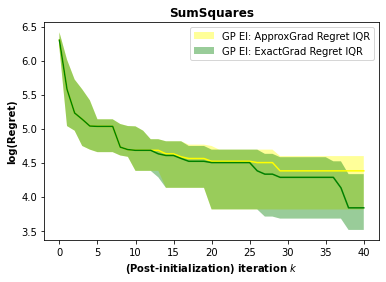

In [125]:
### Visualise!

title = func
plt.figure()

plt.plot(median_approx, color = 'Yellow')
plt.plot(median_exact, color = 'Green')

xstar = np.arange(0, iters+1, step=1)
plt.fill_between(xstar, lower_approx, upper_approx, facecolor = 'Yellow', alpha=0.4, label='GP EI: ApproxGrad Regret IQR')
plt.fill_between(xstar, lower_exact, upper_exact, facecolor = 'Green', alpha=0.4, label='GP EI: ExactGrad Regret IQR')

plt.title(title, weight = 'bold')
plt.xlabel('(Post-initialization) iteration $\it{k}$', weight = 'bold')
plt.ylabel('log(Regret)', weight = 'bold') 
plt.legend(loc=1) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(0, count, 5))
plt.show() #visualise!

In [118]:
time_approx, time_exact


(1138.017428636551, 4369.488895654678)

In [119]:
np.round(exact_1.acqfunc(Xstar)[0],2).reshape(50,10)


array([[-68.19, -68.19, -68.19, -68.19, -68.19, -68.19, -68.19, -68.19,
        -68.19, -68.19],
       [-68.19, -68.19, -68.19, -68.19, -68.19, -68.19, -68.19, -68.19,
        -68.19, -68.19],
       [-68.19, -68.19, -68.19, -68.19, -68.19, -68.19, -68.19, -68.19,
        -68.19, -68.19],
       [-68.19, -68.19, -68.19, -68.19, -68.19, -68.19, -68.19, -68.19,
        -68.19, -68.19],
       [-68.19, -68.19, -68.19, -68.19, -68.19, -68.19, -68.19, -68.19,
        -68.19, -68.19],
       [-68.19, -68.19, -68.19, -68.19, -68.19, -68.19, -68.19, -68.19,
        -68.19, -68.19],
       [-68.19, -68.19, -68.19, -68.19, -68.19, -68.19, -68.19, -68.19,
        -68.19, -68.19],
       [-68.19, -68.19, -68.19, -68.19, -68.19, -68.19, -68.19, -68.19,
        -68.19, -68.19],
       [-68.19, -68.19, -68.19, -68.19, -68.19, -68.19, -68.19, -68.19,
        -68.19, -68.19],
       [-68.19, -68.19, -68.19, -68.19, -68.19, -68.19, -68.19, -68.19,
        -68.19, -68.19],
       [-68.19, -68.19, -68.19

In [120]:
np.round(approx_1._acqWrapper(Xstar),2).reshape(50,10)


array([[-68.19, -68.19, -68.19, -68.19, -68.19, -68.19, -68.19, -68.19,
        -68.19, -68.19],
       [-68.19, -68.19, -68.19, -68.19, -68.19, -68.19, -68.19, -68.19,
        -68.19, -68.19],
       [-68.19, -68.19, -68.19, -68.19, -68.19, -68.19, -68.19, -68.19,
        -68.19, -68.19],
       [-68.19, -68.19, -68.19, -68.19, -68.19, -68.19, -68.19, -68.19,
        -68.19, -68.19],
       [-68.19, -68.19, -68.19, -68.19, -68.19, -68.19, -68.19, -68.19,
        -68.19, -68.19],
       [-68.19, -68.19, -68.19, -68.19, -68.19, -68.19, -68.19, -68.19,
        -68.19, -68.19],
       [-68.19, -68.19, -68.19, -68.19, -68.19, -68.19, -68.19, -68.19,
        -68.19, -68.19],
       [-68.19, -68.19, -68.19, -68.19, -68.19, -68.19, -68.19, -68.19,
        -68.19, -68.19],
       [-68.19, -68.19, -68.19, -68.19, -68.19, -68.19, -68.19, -68.19,
        -68.19, -68.19],
       [-68.19, -68.19, -68.19, -68.19, -68.19, -68.19, -68.19, -68.19,
        -68.19, -68.19],
       [-68.19, -68.19, -68.19

In [121]:
np.mean(exact_1.acqfunc(Xstar)[0]), np.mean(approx_1._acqWrapper(Xstar))


(-68.19354892704335, -67.61687531709552)

In [122]:
exact_1.acqfunc(Xstar)[1].shape


(500, 4)

In [123]:
np.round(exact_1.acqfunc(Xstar)[1],2) 


array([[-0., -0., -0., -0.],
       [-0., -0., -0., -0.],
       [-0., -0., -0., -0.],
       ...,
       [-0., -0., -0., -0.],
       [-0., -0., -0., -0.],
       [-0., -0., -0., -0.]])

In [124]:
np.mean(exact_1.acqfunc(Xstar)[1])


-0.06859971929316959